In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import holidays

df = pd.read_csv('../../data/data.csv')
df.rename(columns={'CAMPAIGN_TYPE ':'CAMPAIGN_TYPE', 'FREE TRIALS': 'FREE_TRIALS'}, inplace=True)
nsize= df.shape[0]
nsize

14108

In [6]:
def remove_outliers_iqr(data, column, multiplier=1.5):
    if column not in data.columns:
        raise ValueError(f"Column '{column}' not found in DataFrame.")

    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1

    # Define the bounds for outliers with a tighter multiplier
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR

    # Filter the DataFrame
    filtered_data = data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

    return filtered_data


In [7]:
# df = remove_outliers_iqr(df, 'COST', 1.0)
# df = remove_outliers_iqr(df, 'FREE_TRIALS', 1.0)
# df

REPORT_DATE             ATL_OR_DR CAMPAIGN_TYPE         CHANNEL  \
0        6/9/2023  DR - Direct Response         Title     paid social   
1       8/29/2023  DR - Direct Response         Title             app   
2       7/23/2023  ATL - Above The Line         Title     paid social   
4       8/31/2022  ATL - Above The Line         Title     paid social   
5       8/27/2023  ATL - Above The Line         Title     paid social   
...           ...                   ...           ...             ...   
14101  12/24/2023  ATL - Above The Line         Title             ctv   
14102   7/28/2022  ATL - Above The Line        Launch  online display   
14103   2/23/2024  ATL - Above The Line         Brand            bvod   
14104   4/21/2024  ATL - Above The Line         Title             ooh   
14107   2/17/2023  DR - Direct Response         Title         youtube   

           COST  FREE_TRIALS  
0       7784.31     86401.15  
1       2474.31      2956.74  
2      10222.82     12513.08  
4       2081.06     21758.33  
5       2081.12     16865.54  
...         ...          ...  
14101   1485.02     36855.19  
14102  19477.42     18960.31  
14103   1478.78     16941.67  
14104    839.25      5727.03  
14107   7385.46     17770.26  

[10649 rows x 6 columns]

In [8]:
print(f'Removed {round((nsize - df.shape[0]) / nsize * 100, 0)}%')

Removed 25.0%


In [9]:
'''
1. Data Types Breakdown:
    a. REPORT_DATE: Numerical | (Discrete -> Interval -> DateTime object)
    b. ATL_OR_DR: Categorical | (Nominal  -> String)
    c. CAMPAIGN_TYPE: Categorical | (Nominal -> String)
    d. CHANNEL: Categorical | (Nominal -> String)
    e. COST: Quantitative | (Continuous -> Ratio -> Float)
    f. FREE TRAILS: Quantitative | ( Continuous -> Ratio -> Float)

2. Data Questions/Concerns:
    a. Is 'FREE TRAILS' a generated impression count from another model? How does a free trial
    lead to continous values instead of discrete?

=> Action Items:
    a. Ensure proper data types across dataframe - DONE
    b. Identify missing data gaps - DONE
    c. Removing 0's based on EDA analysis and log transformation revealing 0 to be a major outlier. Also,
        from a logical business standpoint, doesn't seem right for a campaign to have 0 cost  especailly
        where some 0 cost campaigns generated higher than average free trials. - DONE
'''
colNames = df.columns
categorical = colNames[1:4].values.tolist()
quantitative = colNames[4::].values.tolist()

# Included holidays and Super Bowl dates with the assumption that there are more campaigns being ran during these dates
# Also assuming that holiday seasons have more cost associated with it but higher free trials being generated.
df['REPORT_DATE'] = pd.to_datetime(df['REPORT_DATE'])
us_holidays = holidays.US()
super_bowl_dates = ["2022-02-13", "2023-02-12", "2024-02-11"]
for date in super_bowl_dates:
    us_holidays[date] = "Super Bowl"
df['HOLIDAY_FLAG'] = df['REPORT_DATE'].apply(lambda x: x in us_holidays if pd.notnull(x) else False)
df['LAG_3_HOLIDAY_FLAG'] = df['REPORT_DATE'].apply(lambda x: any((x + pd.Timedelta(days=offset)) in us_holidays for offset in range(1, 4)) if pd.notnull(x) else False)
df['LEAD_3_HOLIDAY_FLAG'] = df['REPORT_DATE'].apply(lambda x: any((x - pd.Timedelta(days=offset)) in us_holidays for offset in range(1, 4)) if pd.notnull(x) else False)

# Extract the month and season from the date to get better insights from metadata.
month_to_season = {
    1: "Winter",
    2: "Winter",
    3: "Spring",
    4: "Spring",
    5: "Spring",
    6: "Summer",
    7: "Summer",
    8: "Summer",
    9: "Fall",
    10: "Fall",
    11: "Fall",
    12: "Winter"
}
df['SEASON'] = df['REPORT_DATE'].dt.month.map(month_to_season)
df['MONTH'] = df['REPORT_DATE'].dt.month_name()

# Combine categorical data for feature engineering to capture larger groups/trends:
# Targeted 'CHANNEL' since that showed slight more relationship with free trial and
# cost with other categorical variables.
df['CHANNEL_ATL_OR_DR'] = df['CHANNEL'] + '_' + df['ATL_OR_DR']
df['CHANNEL_CAMPAIGN_TYPE'] = df['CHANNEL'] + '_' + df['CAMPAIGN_TYPE']

categorical.extend(['HOLIDAY_FLAG', 'LAG_3_HOLIDAY_FLAG', 'LEAD_3_HOLIDAY_FLAG',
                    'SEASON', 'CHANNEL_ATL_OR_DR', 'CHANNEL_CAMPAIGN_TYPE', 'MONTH'])

# Combine numerical data for feature engineering:
# Created KPI metric efficency cost per free trial generated
df['COST_PER_FREE_TRIALS'] = df['COST'] / df['FREE_TRIALS']
df['COST_BY_FREE_TRIALS'] = df['COST'] * df['FREE_TRIALS']
quantitative.extend(['COST_PER_FREE_TRIALS','COST_BY_FREE_TRIALS'])

# Results
print(f'Categorical | {len(categorical)}: {categorical}\nQuantitative | {len(quantitative)}: {quantitative} \n')
print(f'Table Dimension: {df.shape} \n')
df.info()

Categorical | 10: ['ATL_OR_DR', 'CAMPAIGN_TYPE', 'CHANNEL', 'HOLIDAY_FLAG', 'LAG_3_HOLIDAY_FLAG', 'LEAD_3_HOLIDAY_FLAG', 'SEASON', 'CHANNEL_ATL_OR_DR', 'CHANNEL_CAMPAIGN_TYPE', 'MONTH']
Quantitative | 4: ['COST', 'FREE_TRIALS', 'COST_PER_FREE_TRIALS', 'COST_BY_FREE_TRIALS'] 

Table Dimension: (10649, 15) 

<class 'pandas.core.frame.DataFrame'>
Index: 10649 entries, 0 to 14107
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   REPORT_DATE            10649 non-null  datetime64[ns]
 1   ATL_OR_DR              10649 non-null  object        
 2   CAMPAIGN_TYPE          10649 non-null  object        
 3   CHANNEL                10649 non-null  object        
 4   COST                   10649 non-null  float64       
 5   FREE_TRIALS            10649 non-null  float64       
 6   HOLIDAY_FLAG           10649 non-null  bool          
 7   LAG_3_HOLIDAY_FLAG     10649 non-null  bool         

### Univariate Analysis on Continuous Data

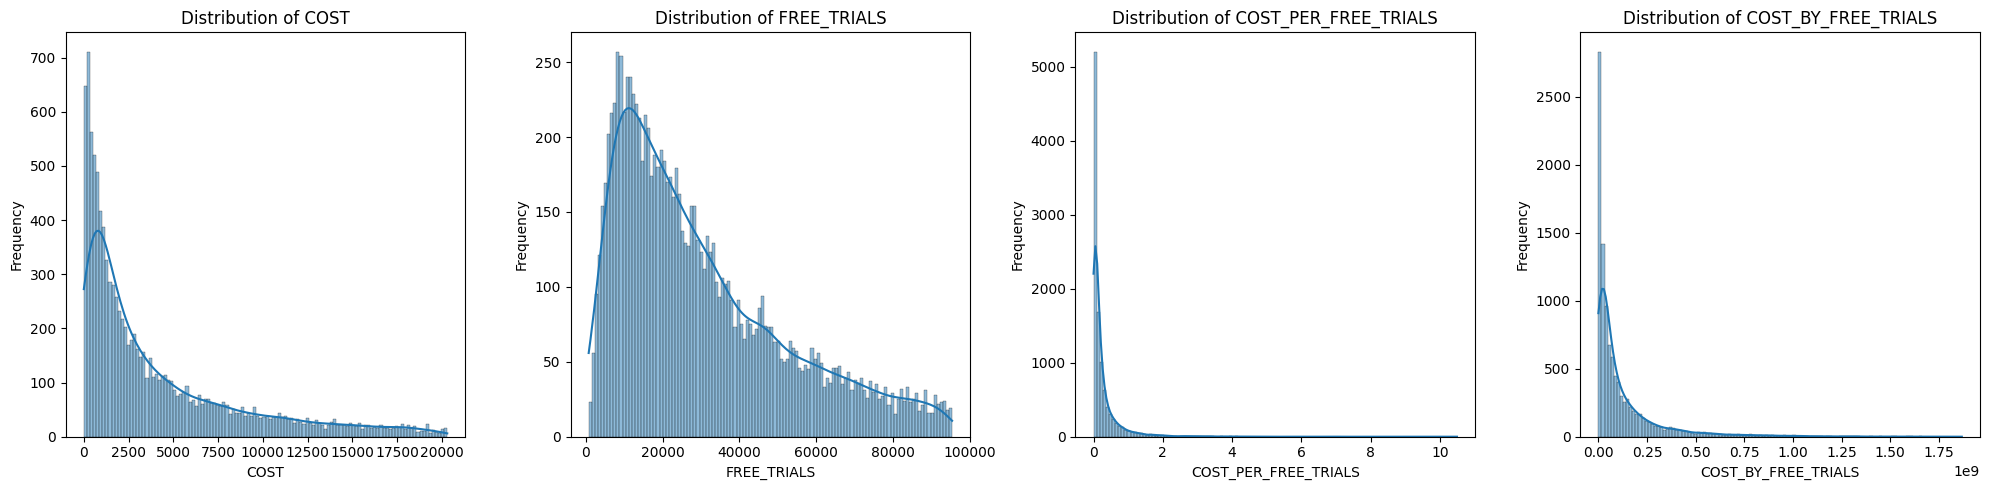

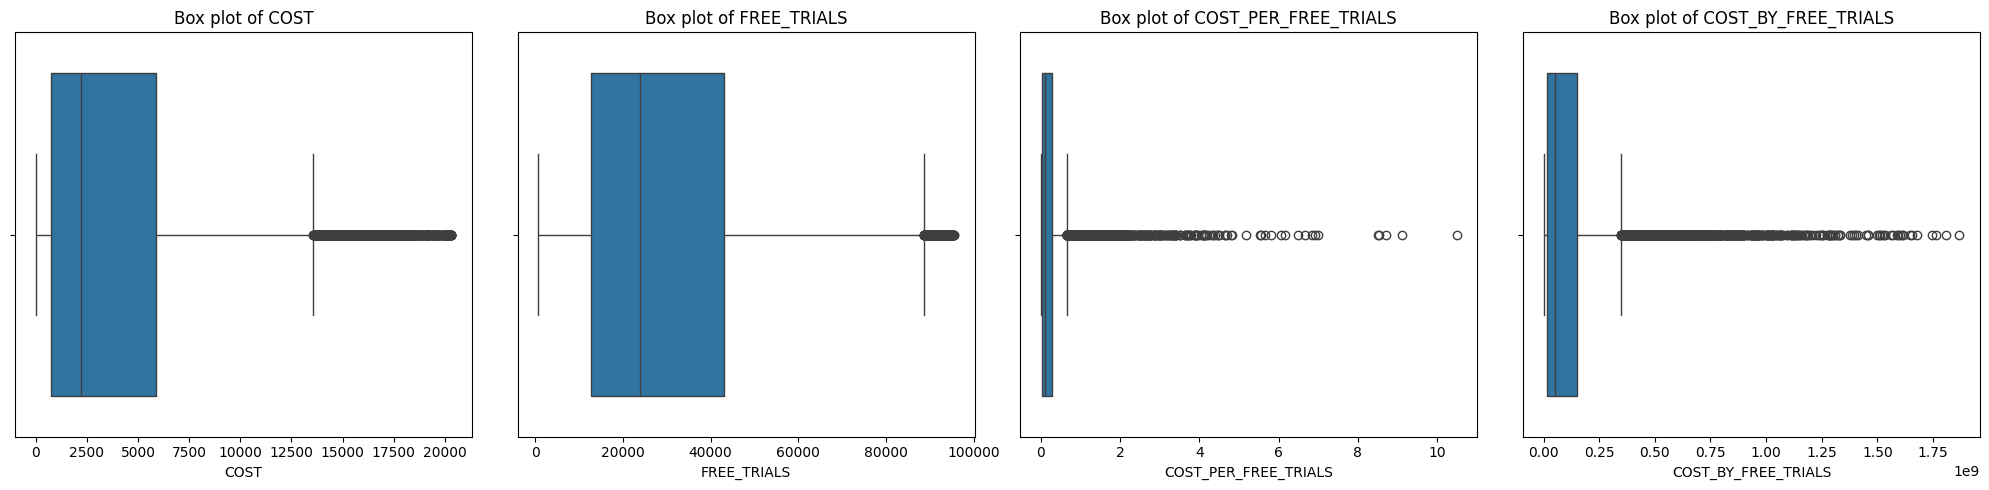

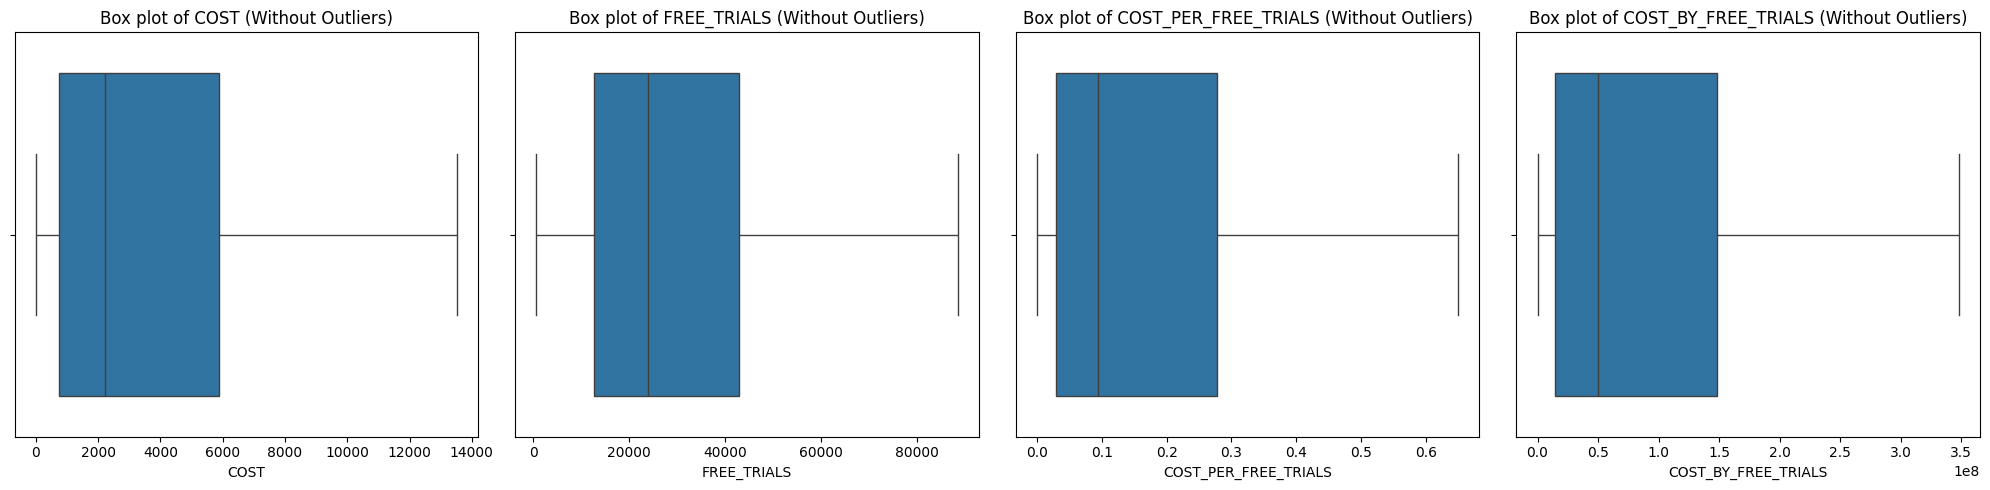

COST   FREE_TRIALS  COST_PER_FREE_TRIALS  COST_BY_FREE_TRIALS
count  10649.000000  10649.000000          10649.000000         1.064900e+04
mean    4125.466979  30339.413135              0.270463         1.248744e+08
std     4630.029588  22322.852971              0.543298         1.968312e+08
min        0.000000    719.360000              0.000000         0.000000e+00
25%      754.790000  12661.620000              0.028712         1.445117e+07
50%     2230.540000  23929.690000              0.093430         4.963691e+07
75%     5866.920000  43020.890000              0.277494         1.480019e+08
max    20308.080000  95456.530000             10.491108         1.868209e+09

In [10]:
'''
Single Variation Continuous Analysis via Histogram/Boxplots:

1. All visuals shows a right skewed distribution with outliers on the right side. So, the mean will be greater than the median.

2. All visuals show data points are clustered around the lower ends and extreme outliers causing the positive skewness.

3. The max values for all data, (COST = 3M, FREE_TRIALS = 2M), are significantly larger than the  (IQR) and mean values,
validating the outliers. More analysis is needed to determine if these should be removed or kept.

4. With such skewness, median would be a more viable measure of central tendency than the mean.

5. Most of the cluster of COST is around 0 which is surprising because I wouldn't have guessed the majority of campaigns to incur 0 expenses.
Is 0 a placeholder for missing data?

6.  All visuals violates Linear Regression's assumption of normality. Need to log transform this feature to normalize the data and reduce outlier
impact

7. FREE TRIALS has a broader distribution of values giving incentives to companies/clients to really optimize their campaign stratgey.
This also signals that some campaigns can also genterate minimal free trials.

8. COST is more concentrated near zero. This tell us that it's either relatively inexpensive and consistent when it comes the cost of runnning a
campaign or companies aren't allocating enough to run campaigns.

9. The lowest free trial generated for a campaign is 500. Interesting it's not 0 unlike COST. Is 500 suppose to repersent 0?

10. A lot of outliers are visible in boxplot visuals. The fact that we have a lot of points clustered around the upper whisker makes me thinks
there is an actual reason behind such concentration of data points for cost and free trials. (IE: Segmentation Analysis)

11. COST/FREE TRIALS are generally on the lower end. We don't see a lot of campaigns being exorbitantly expensive or generating a lot of free trials.
    a. Campaigns generally cost $5,000-$10,000
    b. campaings genearlly generate 20,000-40,000 free trials
    c. having smaller values means more efficency.

12. What separates the pack of companies/clients that are spending exorbitant amount on campaaigns? What/why are they doing differently?

=> Action Items:
    a. Log Transformation on 'COST' and 'FREE TRIALS'. - DONE
    b. Single Variation Continuous Analysis using boxplots - DONE
    c. Covaritation Continuous Analysis between 'COST' and 'FREE TRIALS' using a scatterplot. - DONE
    d. Validate assumption that cost and free trials doesn't have a strong linear relationship. - DONE
    e. Create low, medium, high spenders as binning categories for COST. Can be usefulr for customer
    segmentation analysis
'''
# Create a grid layout
num_cols = len(quantitative)
ncols = 4  # Set the number of columns per row
nrows = (num_cols // ncols) + (num_cols % ncols > 0)  # Adjust rows dynamically based on total columns
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 5 * nrows))  # Wider figure for 4 columns

# Plot each quantitative column
for i, quant_col in enumerate(quantitative):
    sns.histplot(df[quant_col], kde=True, bins=118, ax=axes[i]) #118 bins | bin size ~= SqRoot(n):
    axes[i].set_title(f'Distribution of {quant_col}')
    axes[i].set_xlabel(quant_col)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

num_cols = len(quantitative)
ncols = 4  # Number of columns per row
nrows = (num_cols // ncols) + (num_cols % ncols > 0)  # Adjust rows dynamically
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 5 * nrows))

# Plot each quantitative column
for i, col in enumerate(quantitative):
    sns.boxplot(x=col, data=df, ax=axes[i])  # Removed palette argument
    axes[i].set_title(f'Box plot of {col}')
    axes[i].set_xlabel(col)

plt.tight_layout()
plt.show()

# Repeat for boxplots without outliers
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 5 * nrows))
axes = axes.flatten() if nrows * ncols > 1 else [axes]

for i, col in enumerate(quantitative):
    sns.boxplot(x=col, data=df, showfliers=False, ax=axes[i])  # Removed palette argument
    axes[i].set_title(f'Box plot of {col} (Without Outliers)')
    axes[i].set_xlabel(col)


plt.tight_layout()
plt.show()
df[quantitative].describe()


In [11]:
np.exp(2)-1

6.38905609893065

In [12]:
np.exp(14)-1

1202603.2841647768

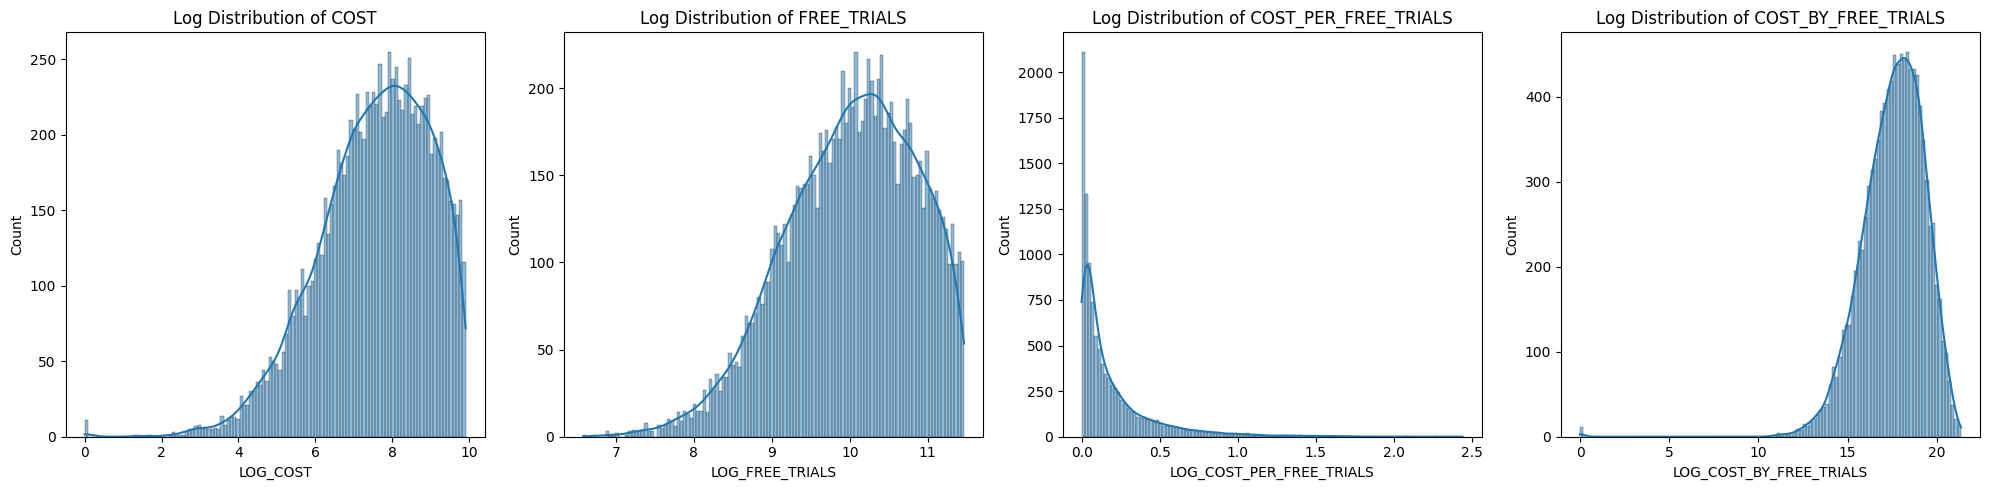

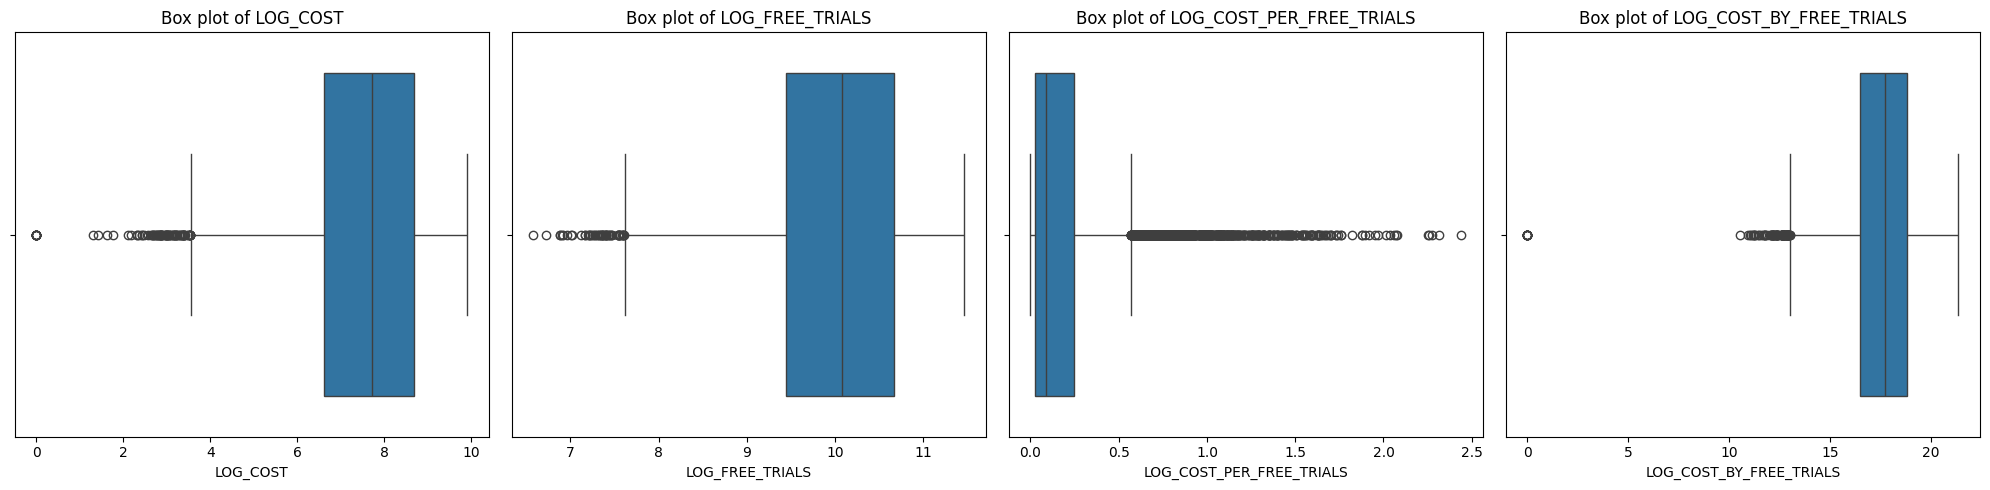

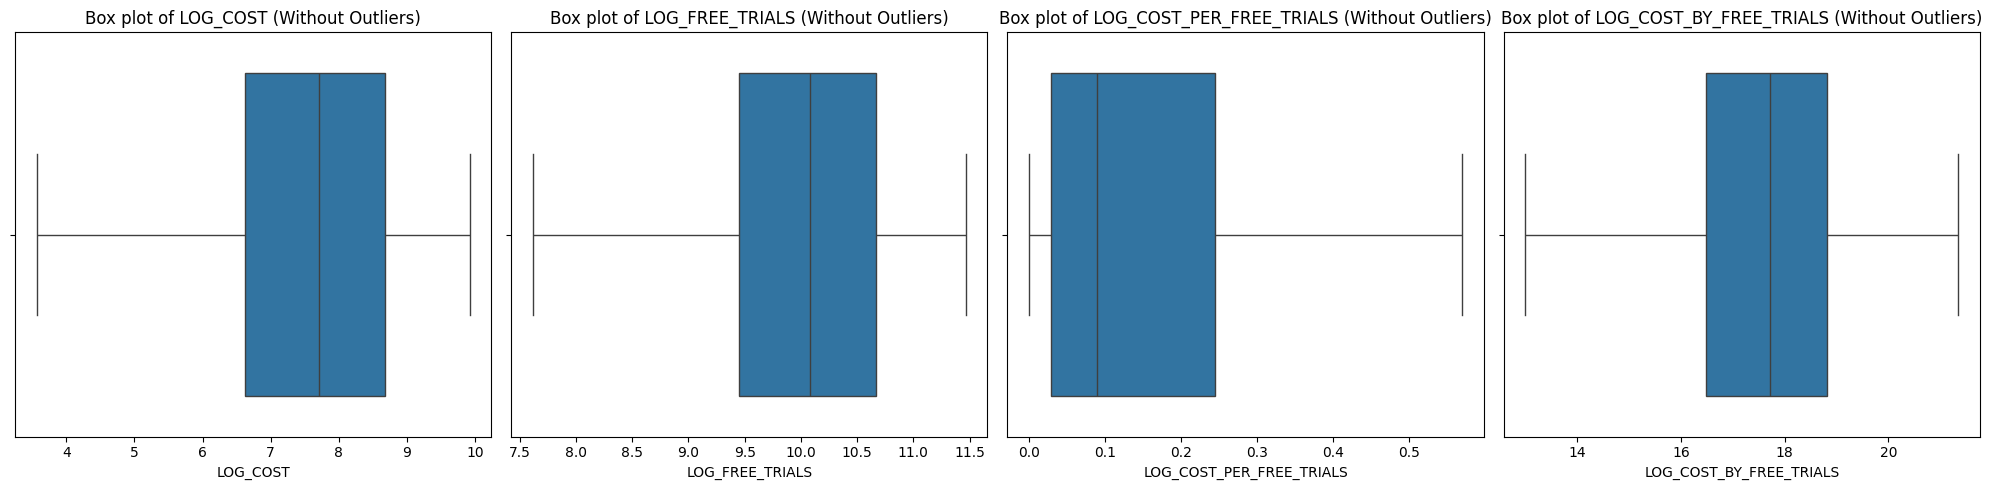

COST   FREE_TRIALS  COST_PER_FREE_TRIALS  COST_BY_FREE_TRIALS
count  10649.000000  10649.000000          10649.000000         1.064900e+04
mean    4125.466979  30339.413135              0.270463         1.248744e+08
std     4630.029588  22322.852971              0.543298         1.968312e+08
min        0.000000    719.360000              0.000000         0.000000e+00
25%      754.790000  12661.620000              0.028712         1.445117e+07
50%     2230.540000  23929.690000              0.093430         4.963691e+07
75%     5866.920000  43020.890000              0.277494         1.480019e+08
max    20308.080000  95456.530000             10.491108         1.868209e+09

In [13]:
'''
Single Variation LOG-Continuous Analysis via Histogram/Boxplots:

1. The log transformation has normalized the data and reduced the impact of outliers. The distribution is now more symmetrical.

2. Cost Data: 68% of all campaigns to fall within one standard deviation of this range $402 -$22,025; the mean/median is $3,000.

3. Free Trials: 68% of all campaigns to fall within one standard deviation of this range 3,000 - 160,000; the mean/median is 22,000.

4. Free Trials has a broader distribution of values than Cost, which validates visuals seen already. You can spend a fixed cost but
have higher variance in free trials generated. This tells us cost is not a good indicator of free trials generated and that there are
more factors at play.

5. The log boxplots still show outliers but now on both tails except for LOG_COST_PER_TRIALS. Left tail might not offer much savings opportunities,
but the right tail might provide opportunities to reduce expenses or look into a more cost savings campaign strategy. The fact that there are low
variances in both tails of log cost and log free trial this could be some clustering behavior.

6. Segmenting data into 2 groups for cost and free trials would be a good baseline for segmentation before running clustering algorithms. 2 groups
refering to your typical spenders and then your abnormal spenders. Can also use 3 groups for low, medium, high costing campaigns and free trials
generated.

7. LOG_COST_PER_TRIALS has less variance than the other log-transformed variables. This could be due to the fact many comapnies adopt similar
startegies/themes/objectives regarding striving for efficent cost per free trial. However, we do have a bucnh of exterme outliers that are
inefficent. Thiscould liely be either misallocation of resources/stategy, or these companies can afford to spend more on campaigns.

8. The fact that there are so many present outliers on oppsoite whiskers for most visuals makes me think these are more than just outliers and
instead suggests distinct business segments/behavioral clusters and/or domain behavior.

=>. Action Items:
    a. Add cateogircal data to the scatterplot to see if there are any relationships between the two.
    b. Filter data on 0's in 'LOG_COST' for more analysis.
    c. Filter data on high 'LOG_COST' with low 'LOG_FREE TRIALS' for more analysis.
    d. Filter data on low 'LOG_COST' and high 'LOG_FREE TRIALS' for more analysis.
    e. Deal with outliers - DONE

'''
num_cols = len(quantitative)
ncols = 4  # Number of columns per row
nrows = (num_cols // ncols) + (num_cols % ncols > 0)  # Dynamically adjust rows
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 5 * nrows))

# Flatten axes for iteration
axes = axes.flatten()

# Plot histograms for log-transformed variables
for i, quant_col in enumerate(quantitative):
    log_transformed = np.log1p(df[quant_col])  # Log-transform
    df[f'LOG_{quant_col}'] = log_transformed  # Add to dataframe
    sns.histplot(log_transformed, kde=True, bins=118, ax=axes[i])
    axes[i].set_title(f'Log Distribution of {quant_col}')
    axes[i].set_xlabel(f'LOG_{quant_col}')

# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

num_cols = len(quantitative)
ncols = 4
nrows = (num_cols // ncols) + (num_cols % ncols > 0)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 5 * nrows))

axes = axes.flatten()

for i, col in enumerate(quantitative):
    sns.boxplot(x=df[f'LOG_{col}'], data=df, ax=axes[i])
    axes[i].set_title(f'Box plot of LOG_{col}')
    axes[i].set_xlabel(f'LOG_{col}')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 5 * nrows))
for i, col in enumerate(quantitative):
    sns.boxplot(x=df[f'LOG_{col}'], data=df, showfliers=False, ax=axes[i])
    axes[i].set_title(f'Box plot of LOG_{col} (Without Outliers)')
    axes[i].set_xlabel(f'LOG_{col}')


plt.tight_layout()
plt.show()

df[quantitative].describe()


### MultiVariate Analysis on Continuous Data

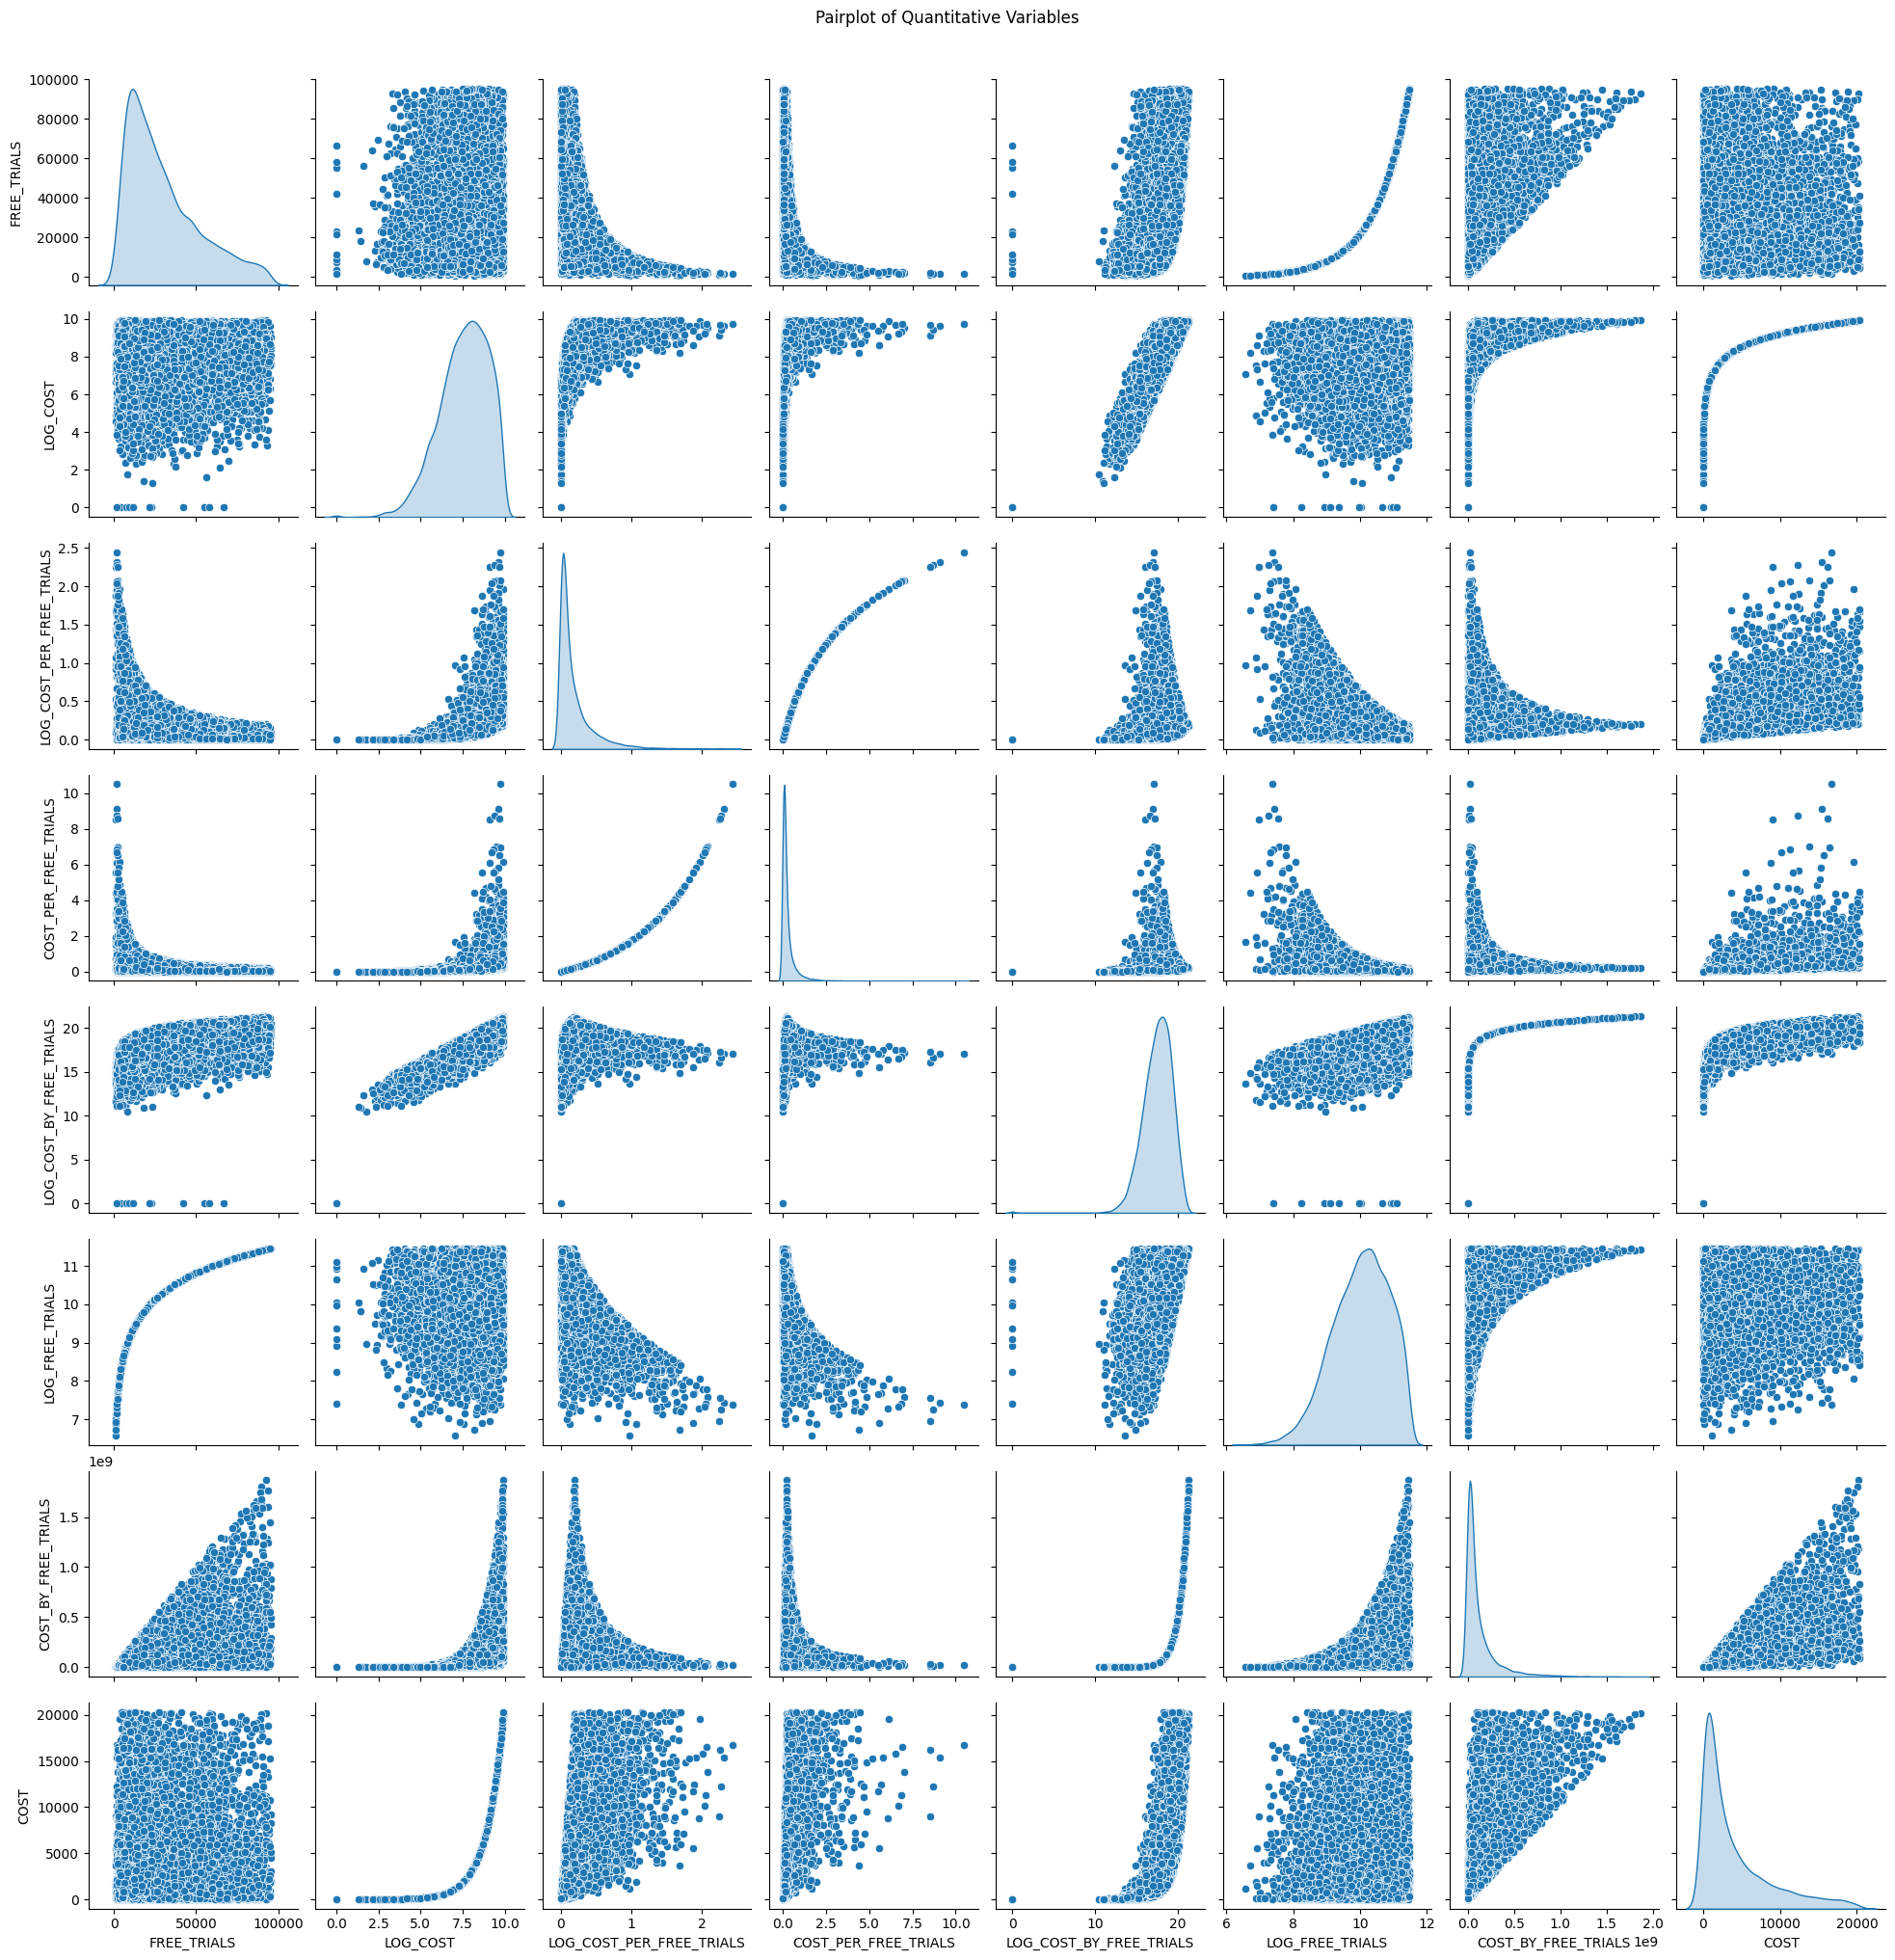

In [14]:
'''
Covariation Analysis using Scatterplot:

1. LOG_COST and LOG_FREE_TRIALS doesn't show a strong linear relationship. There is some positive relationship but we also see diminishing
returns and/or increasing likelihood of a campaign not generating a typical "linearly" free trial count aka risk. Likewise, we see a bunch of campaigns
that had minimal costs and yet generated a lot of free trials. This could be really efficent campaign strategy or incorrect data misrepresentation.
Regardless, somewaht a linear relationship with diminishing returns past a cost threshold.

2. We see a a lot of non-linear relationships. We can either perform more feature enginering like square root or taking the polynomial or we can use a model to capture
relationships beyond linearaity. Overall, no strong evidence of any visuls with any indication of any linear relationship.

3. For campaigns that require minimal cost, there's a wide spread of LOG_COST_PER_FREE_TRIALS signalying high variability in efficiency at lower spending levels. This could be
the "gold standard" comapnies that are succesfull in buidling their brand/lyoalty and customer base and leveraging that to generate free trials at a high efficeint clip (high efficeny).
This is a "sweet spot" because even for campaigns that generated minimal free trials, at least your cost was small too. Therefore, less risk is associated while low cost and can have high
ROI while increasing cost on a campaign drastically increases risk of low free trail genreated.

=>. Action Items:
    a. Add cateogircal data to the scatterplot to see if there are any relationships between the two. - DONE
    b. Filter data on 0's in 'LOG_COST' for more analysis. - DONE
    c. Filter data on high 'LOG_COST' with low 'LOG_FREE TRIALS' for more analysis.
    d. Filter data on low 'LOG_COST' and high 'LOG_FREE TRIALS' for more analysis.
'''
totalColumns = set(df.columns)
totalColumns.remove('REPORT_DATE')

quantitative=list(set(totalColumns) - set(categorical))
quantitative

#LOG_COST_PER_FREE_TRIALS	LOG_COST_BY_FREE_TRIALS
sns.pairplot(df[quantitative], diag_kind='kde', height=2.5)
plt.suptitle('Pairplot of Quantitative Variables', y=1.02)  # Title for the entire plot
plt.show()

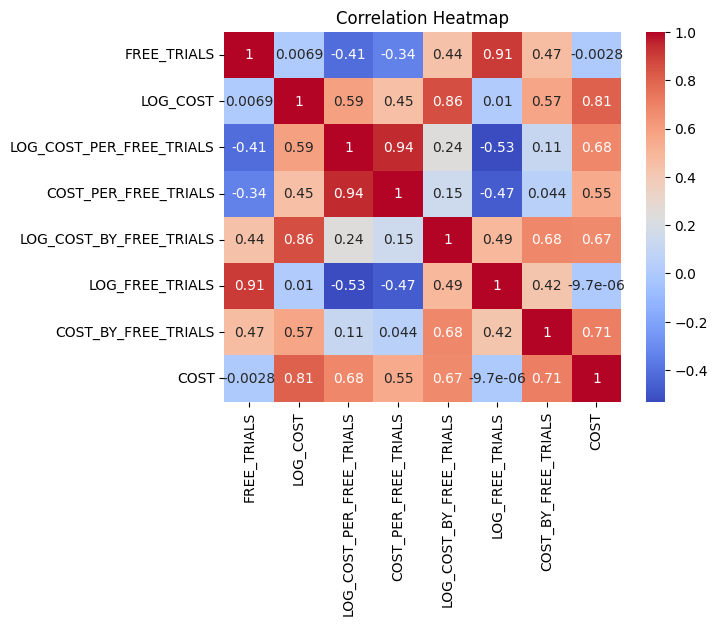

In [15]:
'''
Pearson Correlation using Heatmap

1. Most relationships show weak linaer relationships which is validated in the scatterplot. Since we are predicting FREE_TRIALS,
the heatmap indicates that using a linear model might not be the most effective model to use.

2. Some hot spots are misleading bc they are dervied from feature engineering from previous steps.
'''
sns.heatmap(df[quantitative].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

### Univariate Analysis on Categorical Data

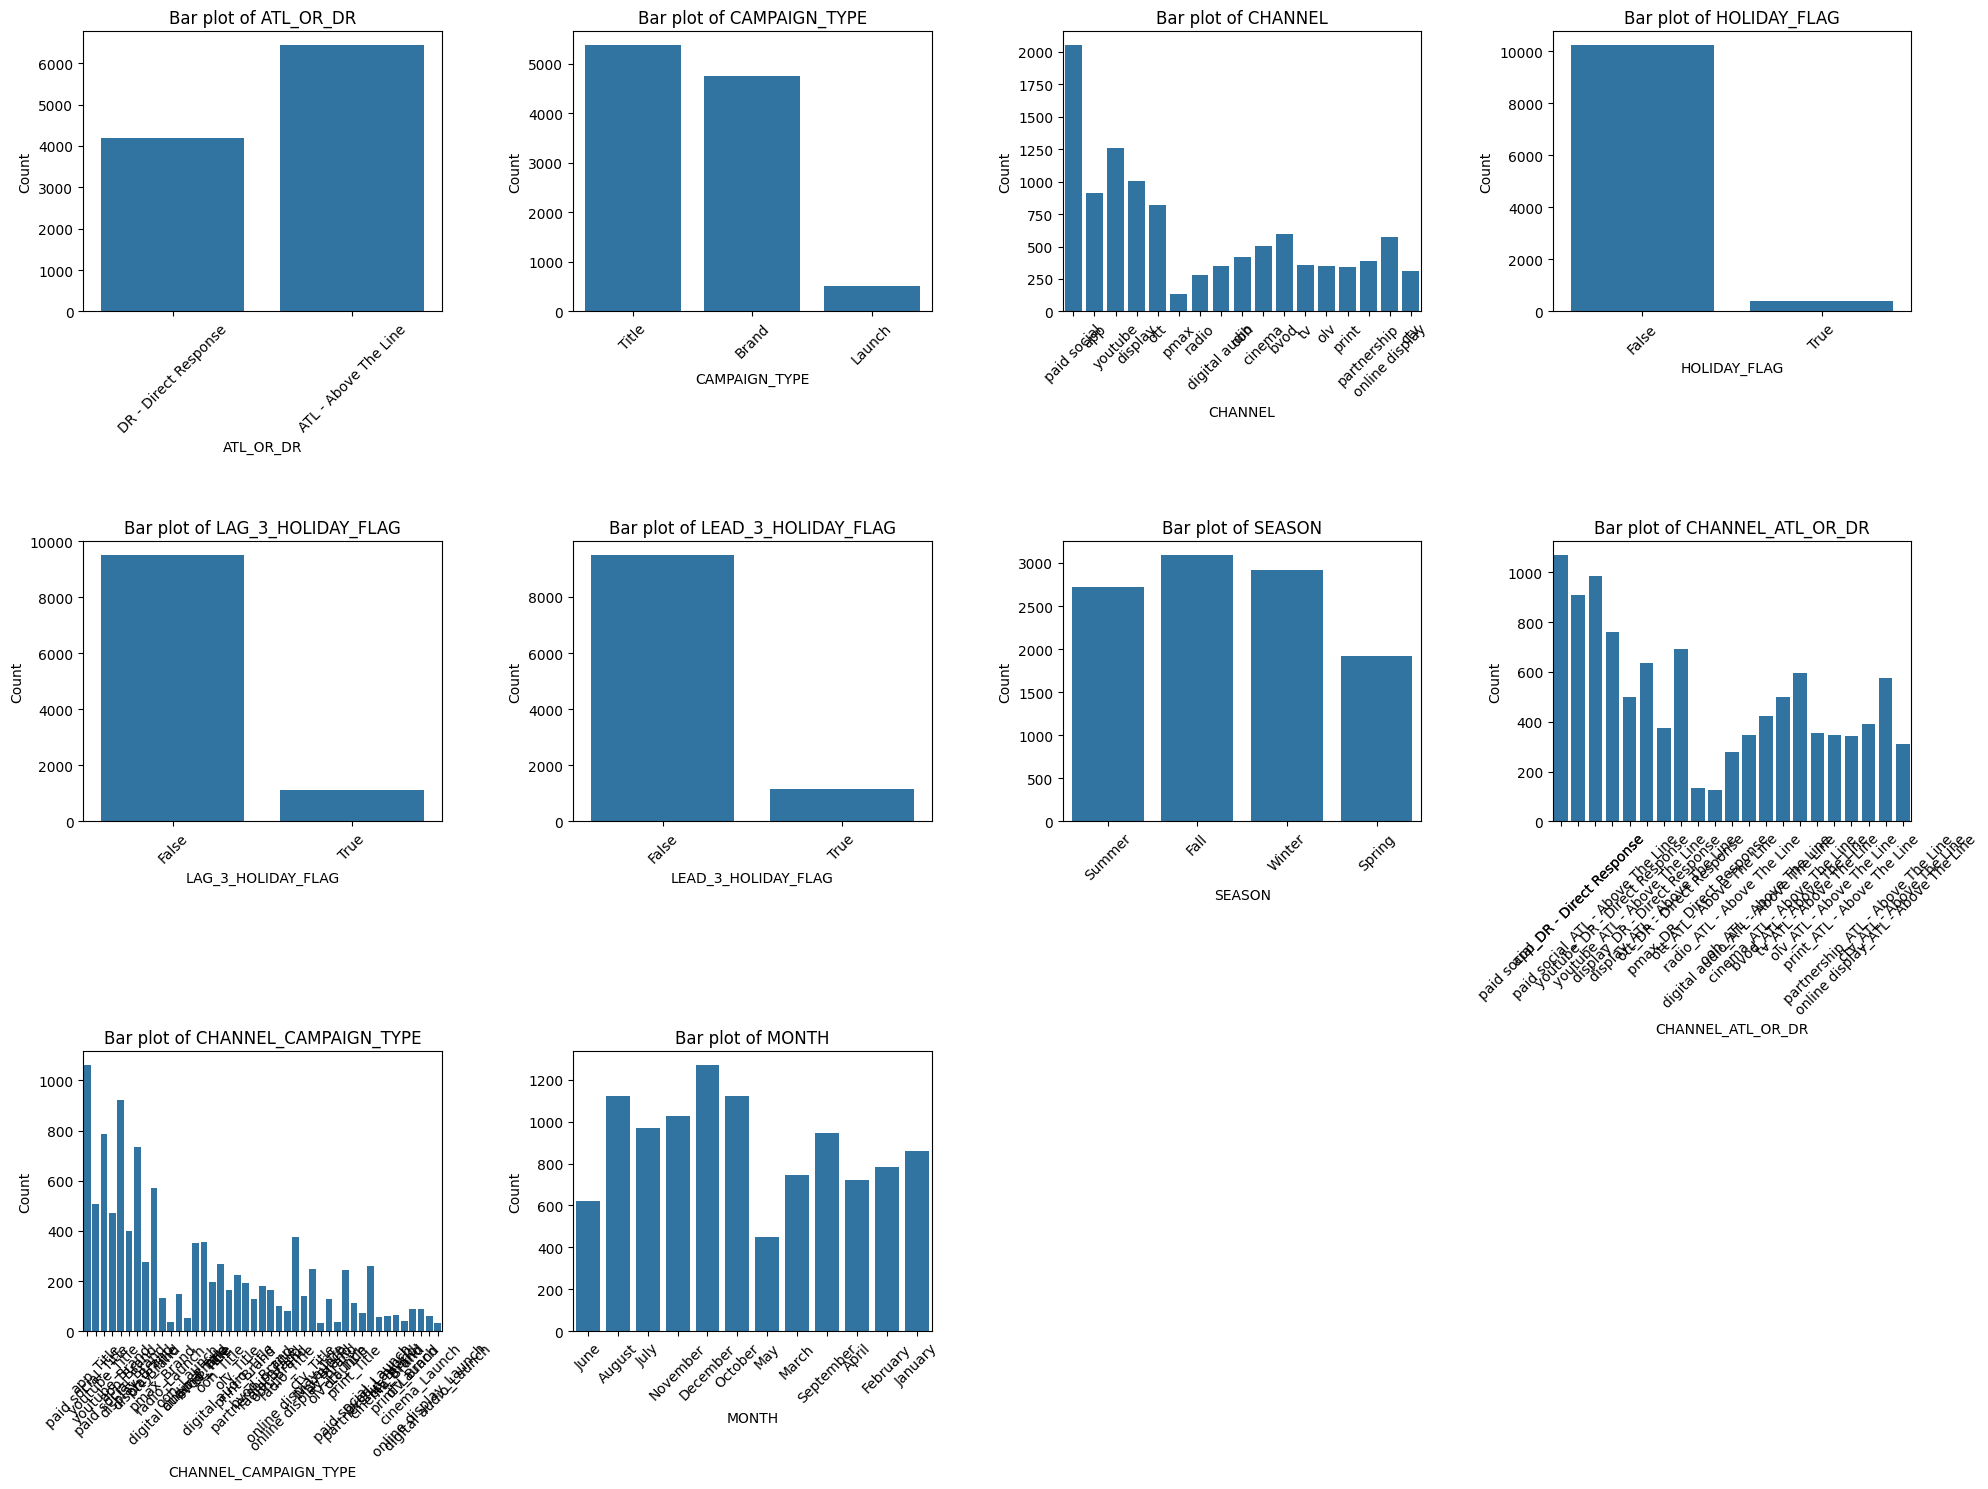

In [16]:
'''
Single Variation Categorical Analysis using Barchart:

1. ATL is a more popular type of campaign over DR. This aligns with your typical business marketing lifecycle where
companies/customers continuosly build and reinforce their brand over time. This is also apparent in the campaign types:
title and brand are more popular while launch campaigns are less frequent. This could also relate to the fact that there
is a high barriers of entry for launching new products or entering new market regions associated with cost. Promotional
campaigns do not exist.

2. Paid Social and other digitial media devices are the most popular over your traditional media devices like TV, radio, and print.
This isn't to infer that these traditional media devices are not effective, but rather the shift in the digital age. Reduce
spending on traditional media devices and reallocating resources to digital media devices could be a good strategy but you might
lose out on niche customers/target audience that can only be reached a certain way.

3. Fall/Winter show the highest number of campaigns being aired. This could be companies/customers wanting to capitalize on the
holiday season. Specifically December shows the highest number of campaigns being aired followed by October and November(Black Friday/
Cyber Monday?)

=> Action Items:
    a. Covariation Analysis between Categorical & Continuous' using Scatterplot and hue
    b. Covariation Analysis between categorical and continuous using boxplot and barcharts
'''
num_cols = len(categorical)
ncols = 4  # Number of columns per row
nrows = (num_cols // ncols) + (num_cols % ncols > 0)  # Dynamically adjust rows
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 5 * nrows))

# Flatten axes for iteration
axes = axes.flatten()

# Plot bar plots for each categorical variable
for i, cat in enumerate(categorical):
    sns.countplot(x=cat, data=df, ax=axes[i])
    axes[i].set_title(f'Bar plot of {cat}')
    axes[i].set_xlabel(cat)
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=45)  # Rotate x-axis labels for better readability

# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


### Multivariate Analysis

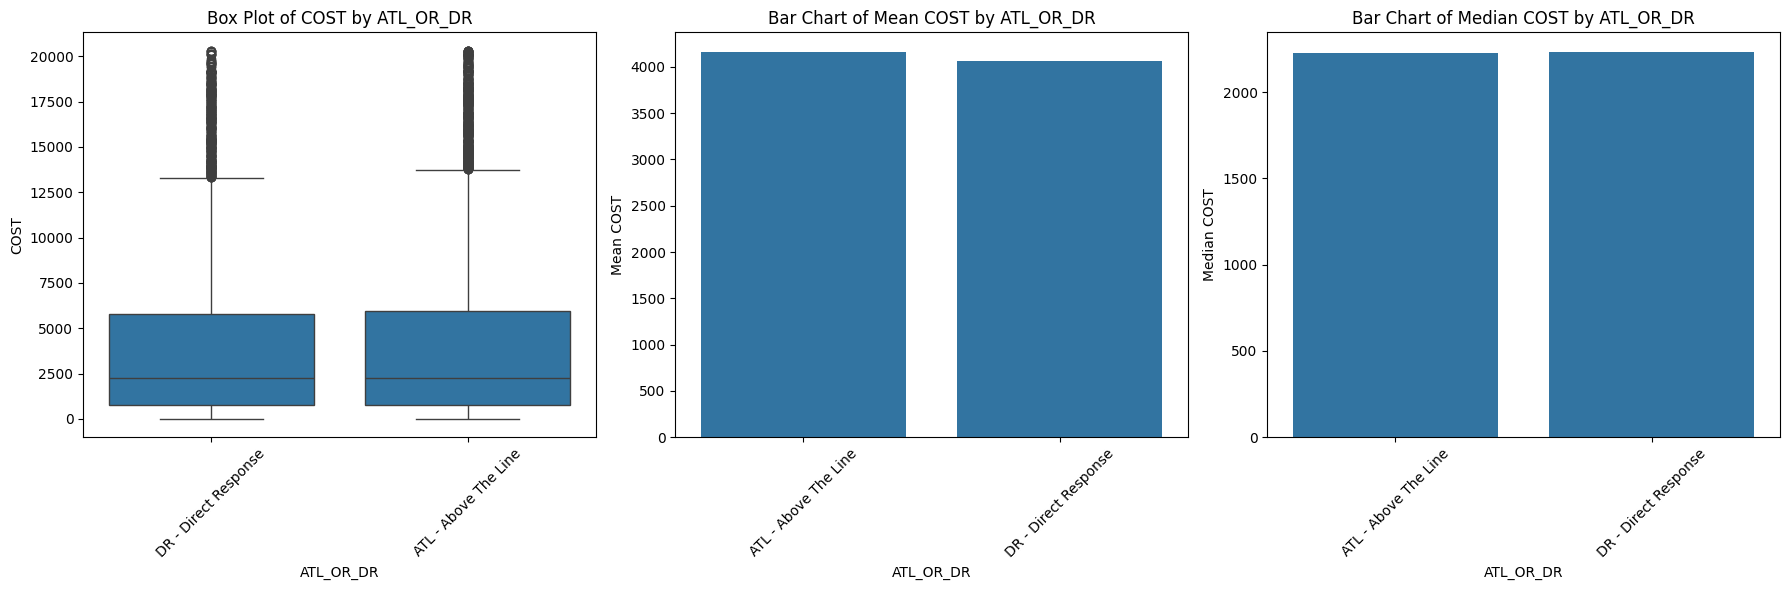

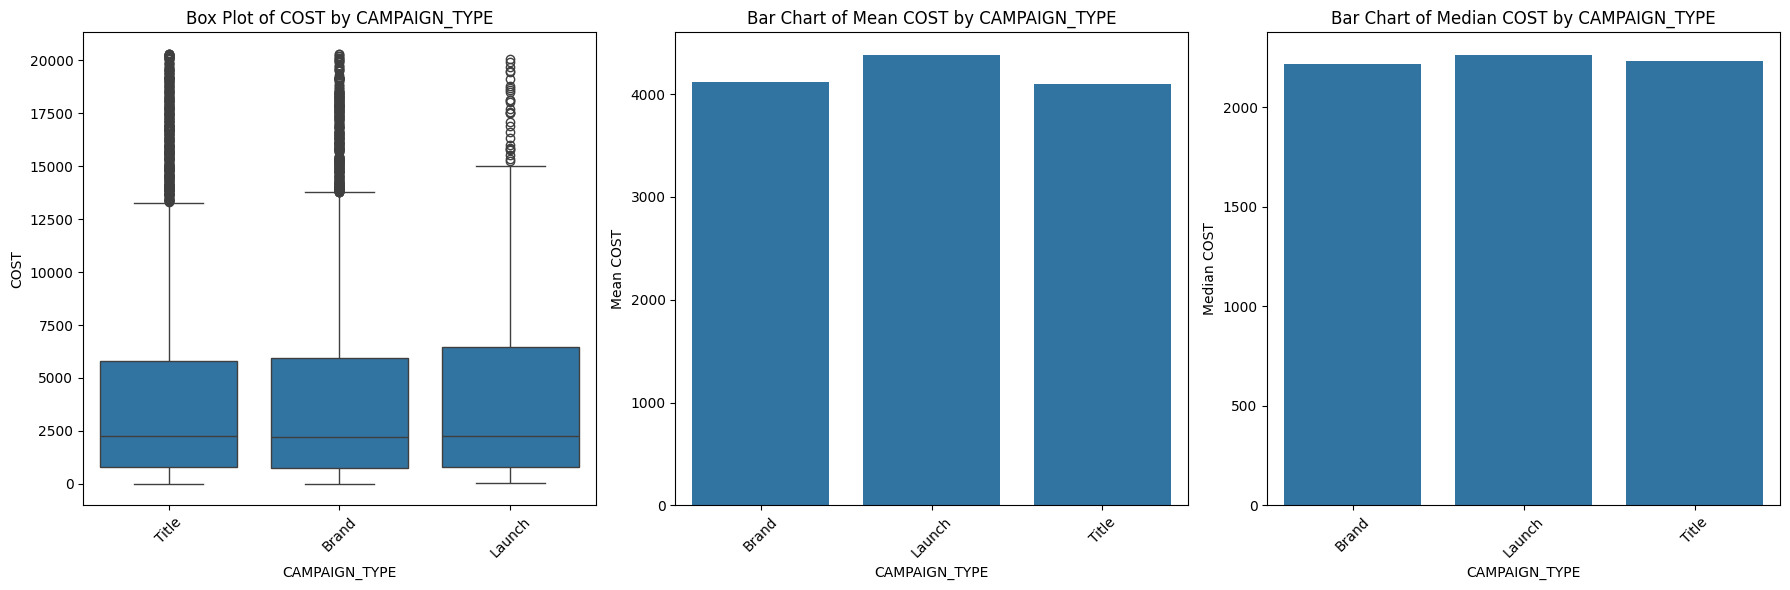

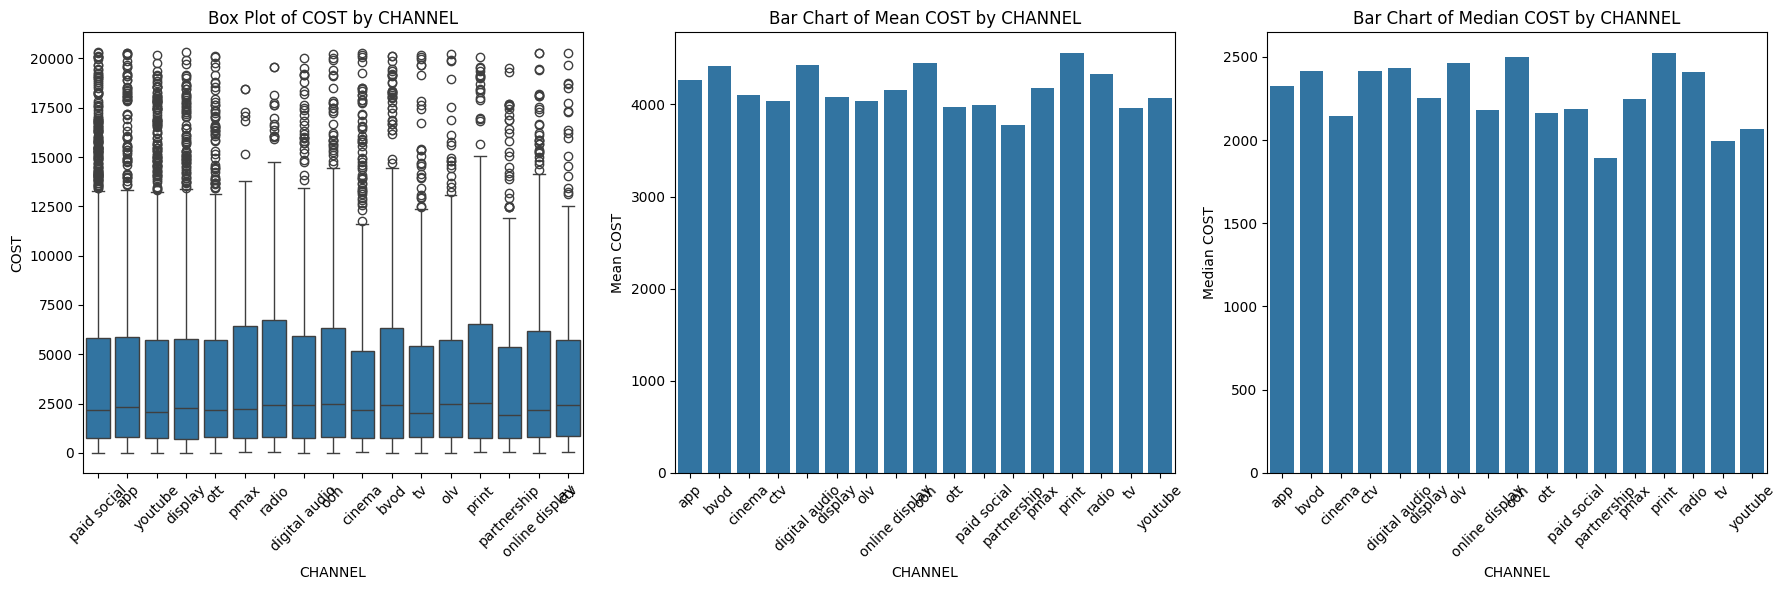

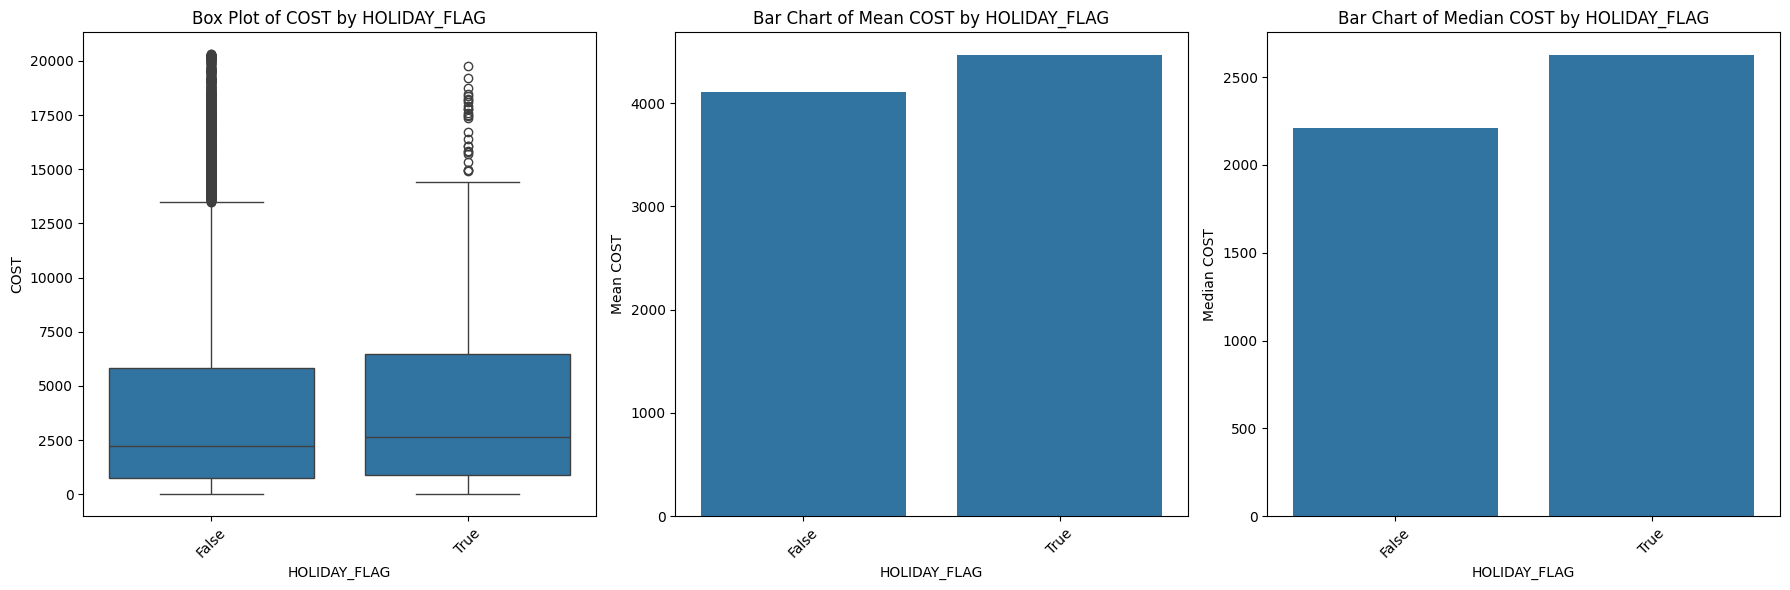

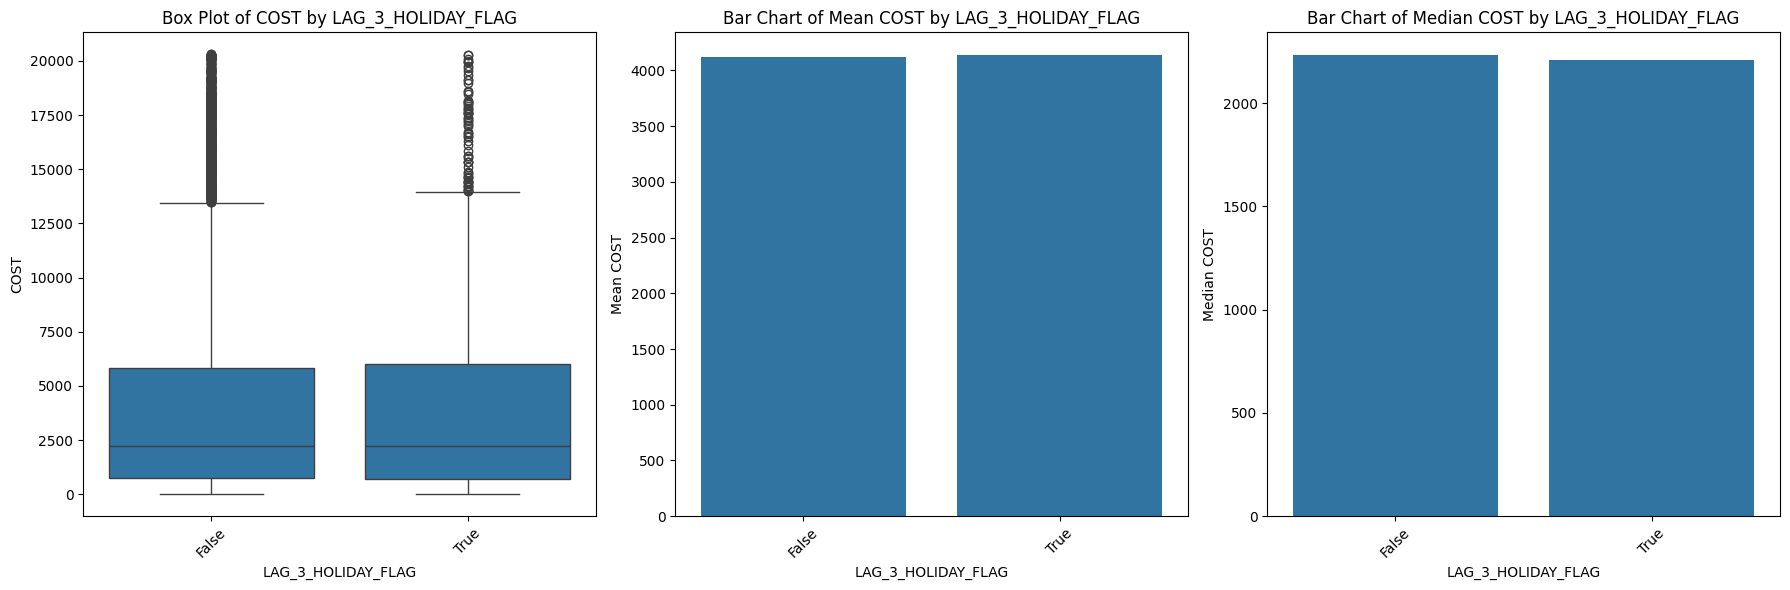

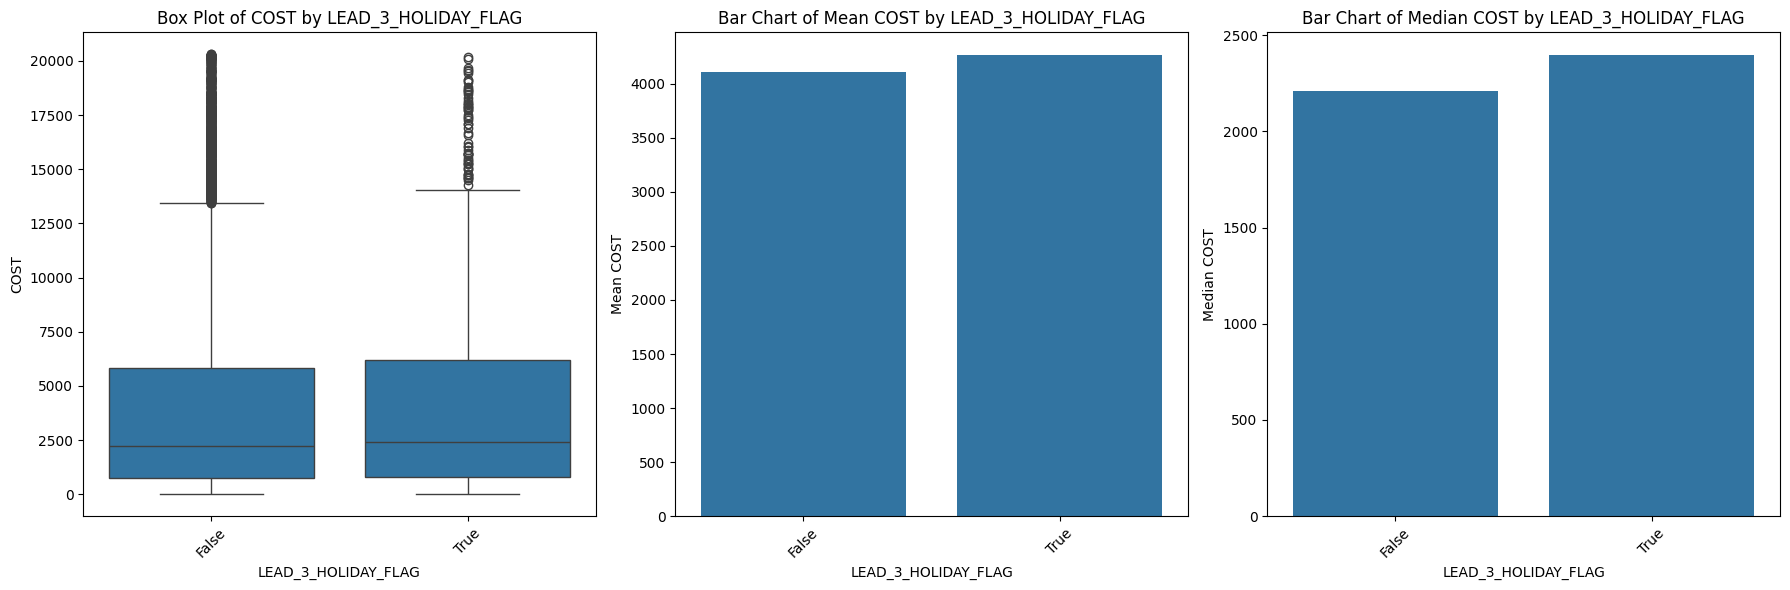

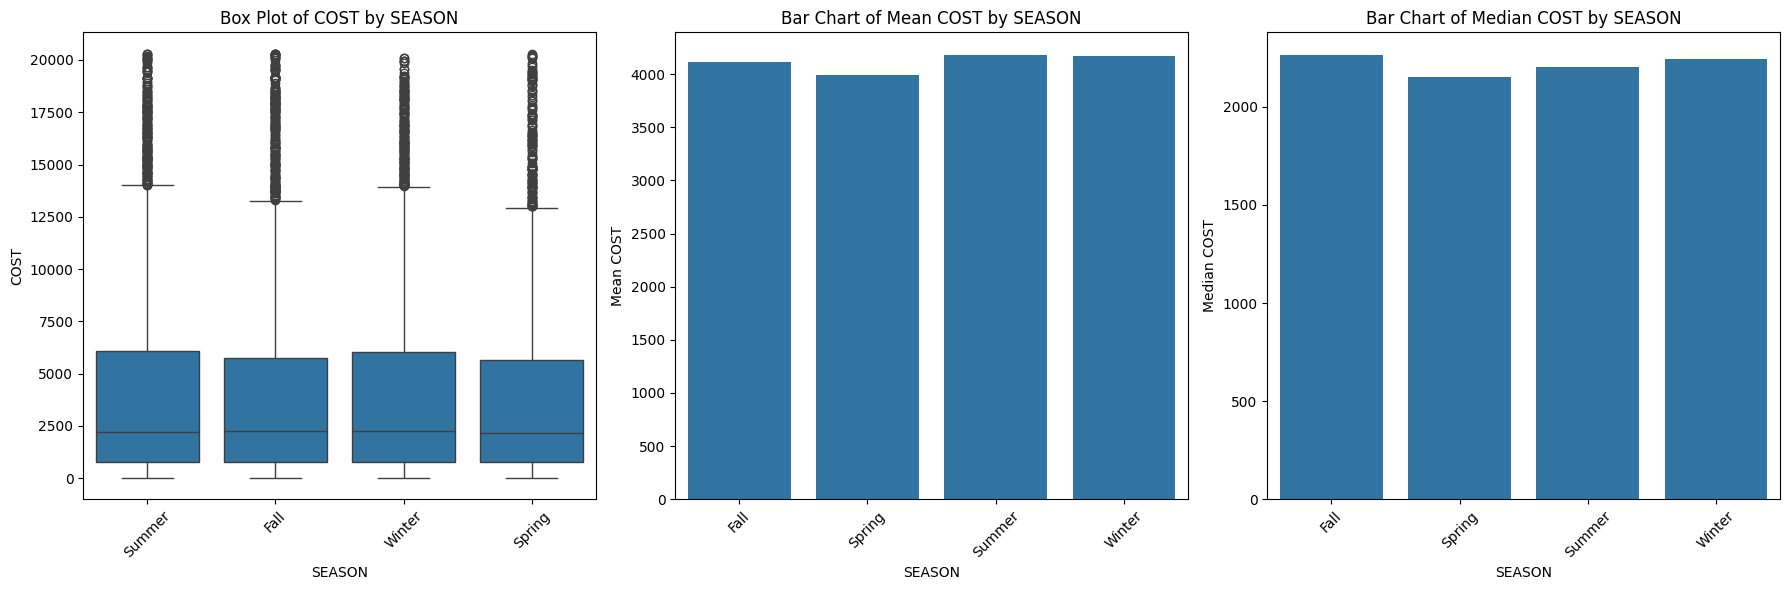

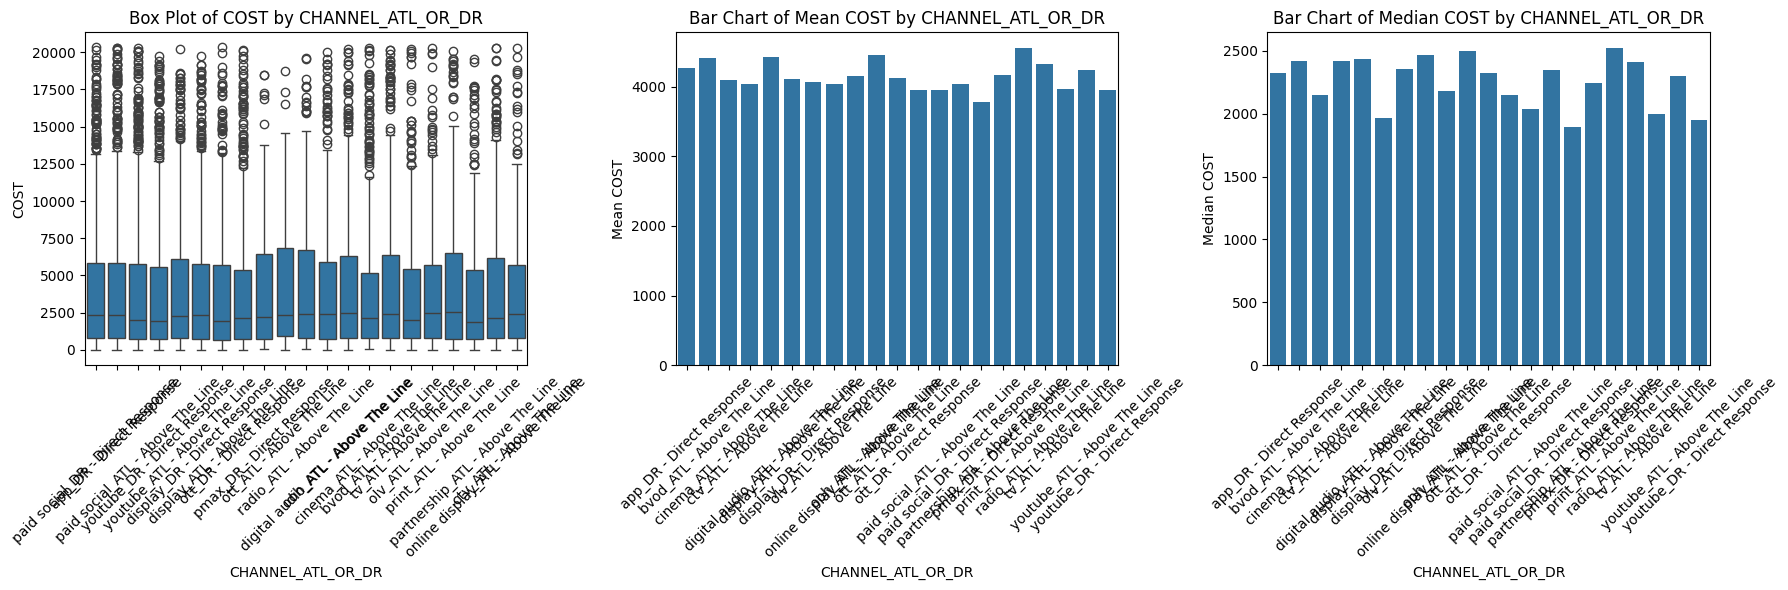

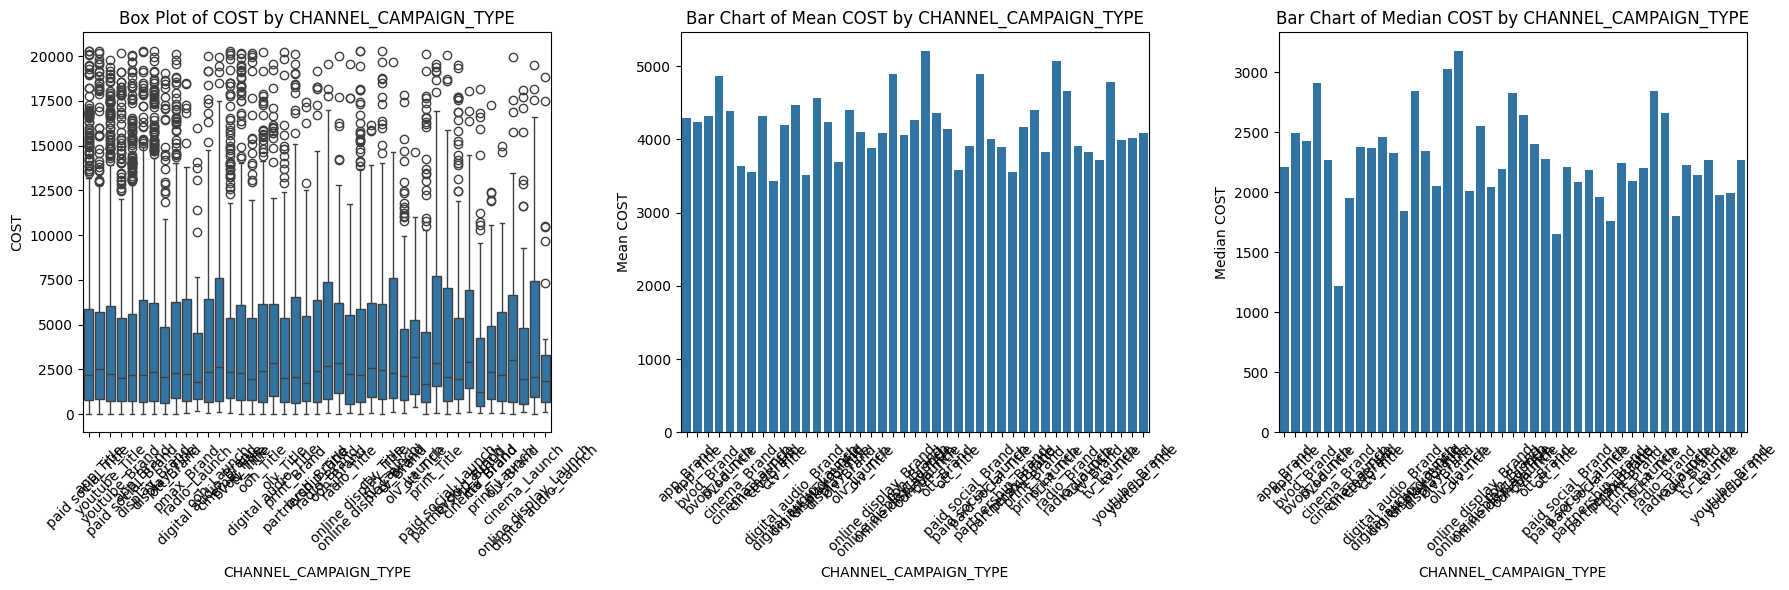

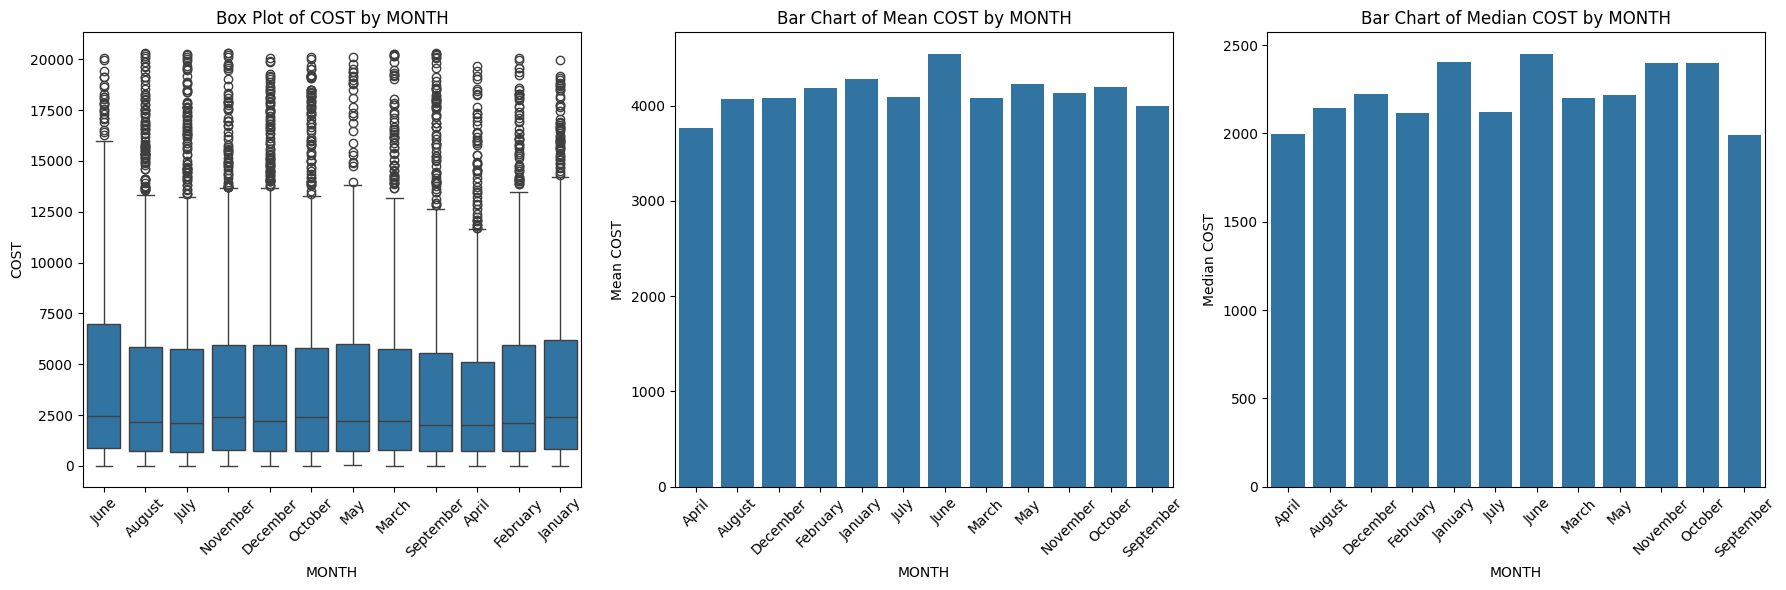

In [17]:
'''
Covariation Analysis between Categorical & Continuous using boxplot and barcharts:

1. ATL tend to have a slight higher cost associated with it than DR.

2. Different channels have a higher/lower cost associated with running a campaign. This
could be one of the driving factors in campaign strategies.

3. It cost more to run on holidays than non-holidays. This can be an area of opportunity
to see if spending more money to run on holidays is worth it or not regarding free trials
generated.

4. Spring tends to be the cheapest season to run a campaign. Perhaps leeast amount of holidays?

5.
'''
for category in categorical:
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # Create side-by-side plots

    # Box Plot
    sns.boxplot(x=category, y='COST', data=df, ax=axes[0])
    axes[0].set_title(f'Box Plot of COST by {category}')
    axes[0].set_xlabel(category)
    axes[0].set_ylabel('COST')
    axes[0].tick_params(axis='x', rotation=45)  # Rotate x-axis labels

    # Bar Chart (Mean)
    mean_bar_data = df.groupby(category)['COST'].mean().reset_index()
    sns.barplot(x=category, y='COST', data=mean_bar_data, ax=axes[1])
    axes[1].set_title(f'Bar Chart of Mean COST by {category}')
    axes[1].set_xlabel(category)
    axes[1].set_ylabel('Mean COST')
    axes[1].tick_params(axis='x', rotation=45)  # Rotate x-axis labels

    # Bar Chart (Median)
    median_bar_data = df.groupby(category)['COST'].median().reset_index()
    sns.barplot(x=category, y='COST', data=median_bar_data, ax=axes[2])
    axes[2].set_title(f'Bar Chart of Median COST by {category}')
    axes[2].set_xlabel(category)
    axes[2].set_ylabel('Median COST')
    axes[2].tick_params(axis='x', rotation=45)  # Rotate x-axis labels

    # Adjust layout
    plt.tight_layout()
    plt.show()


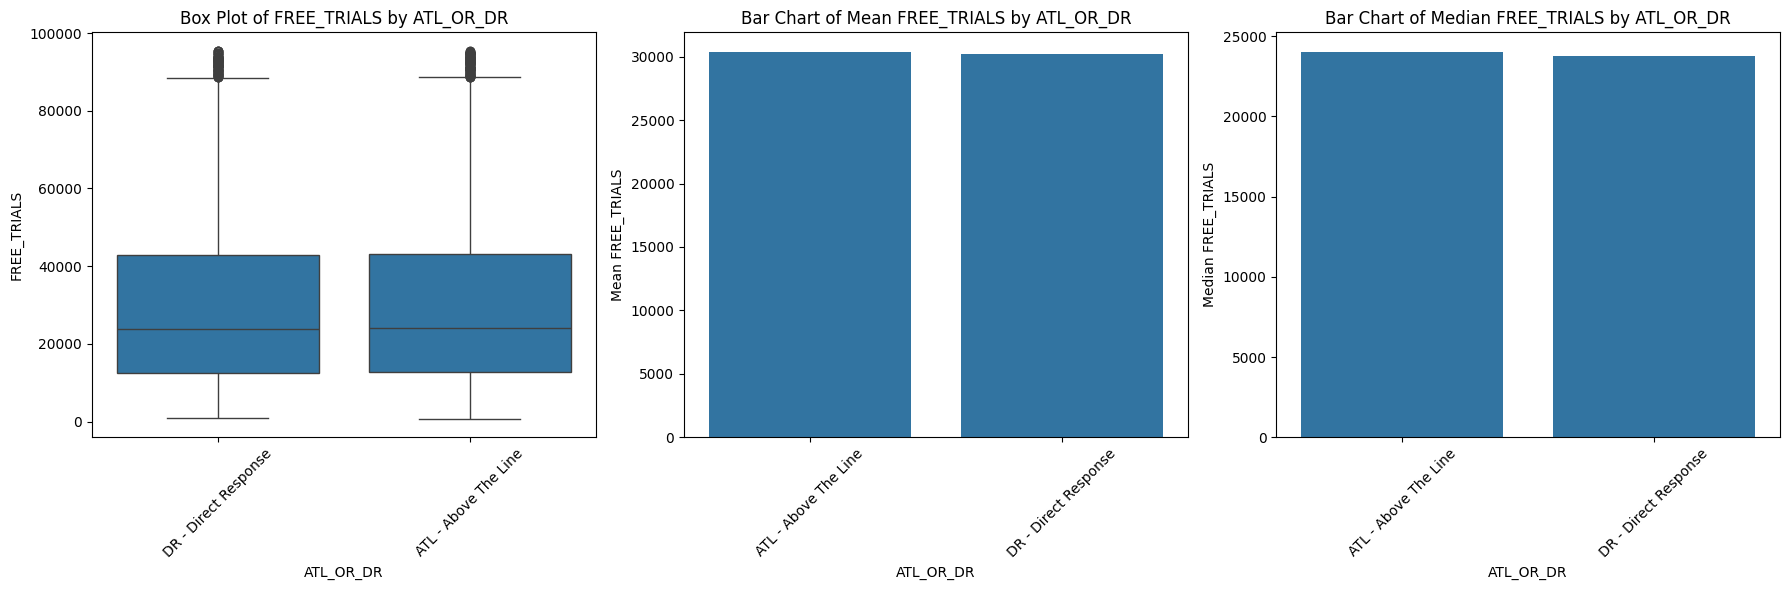

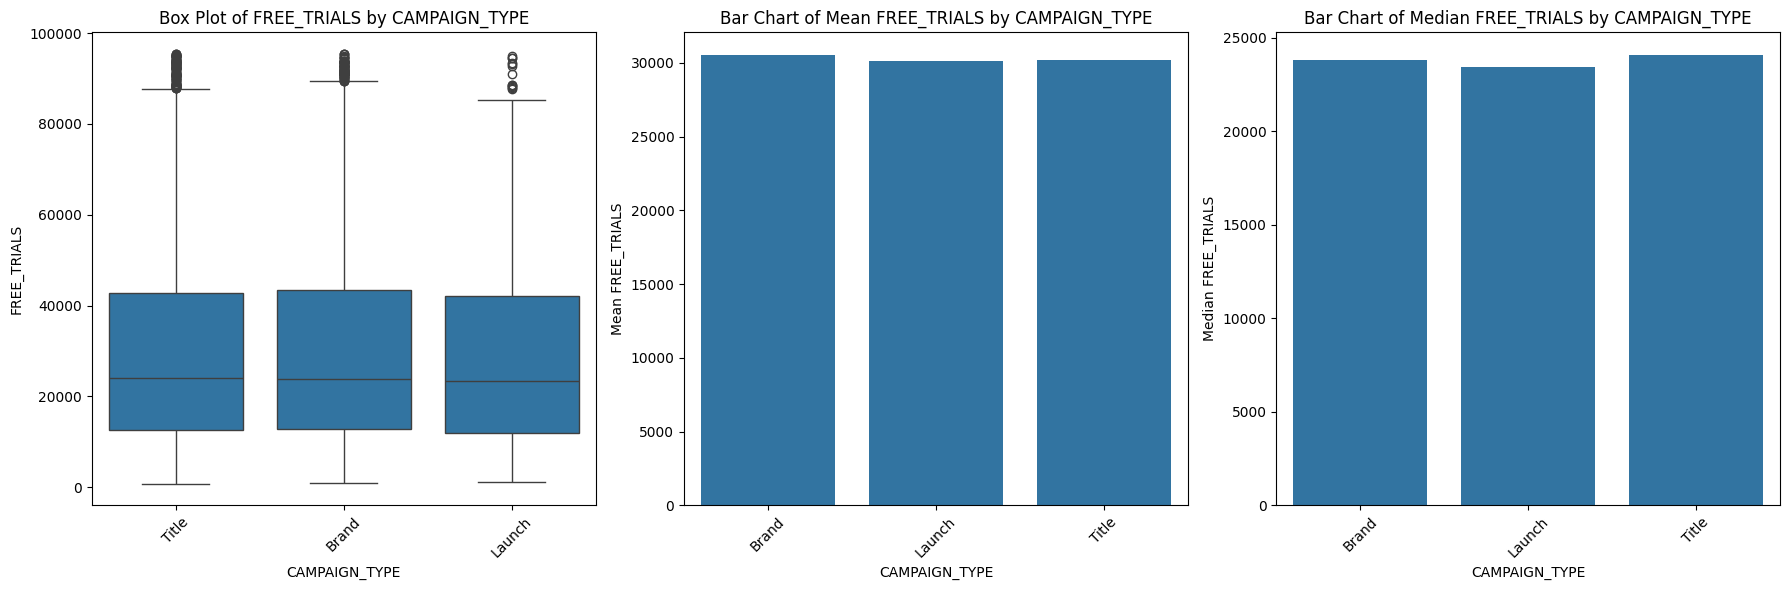

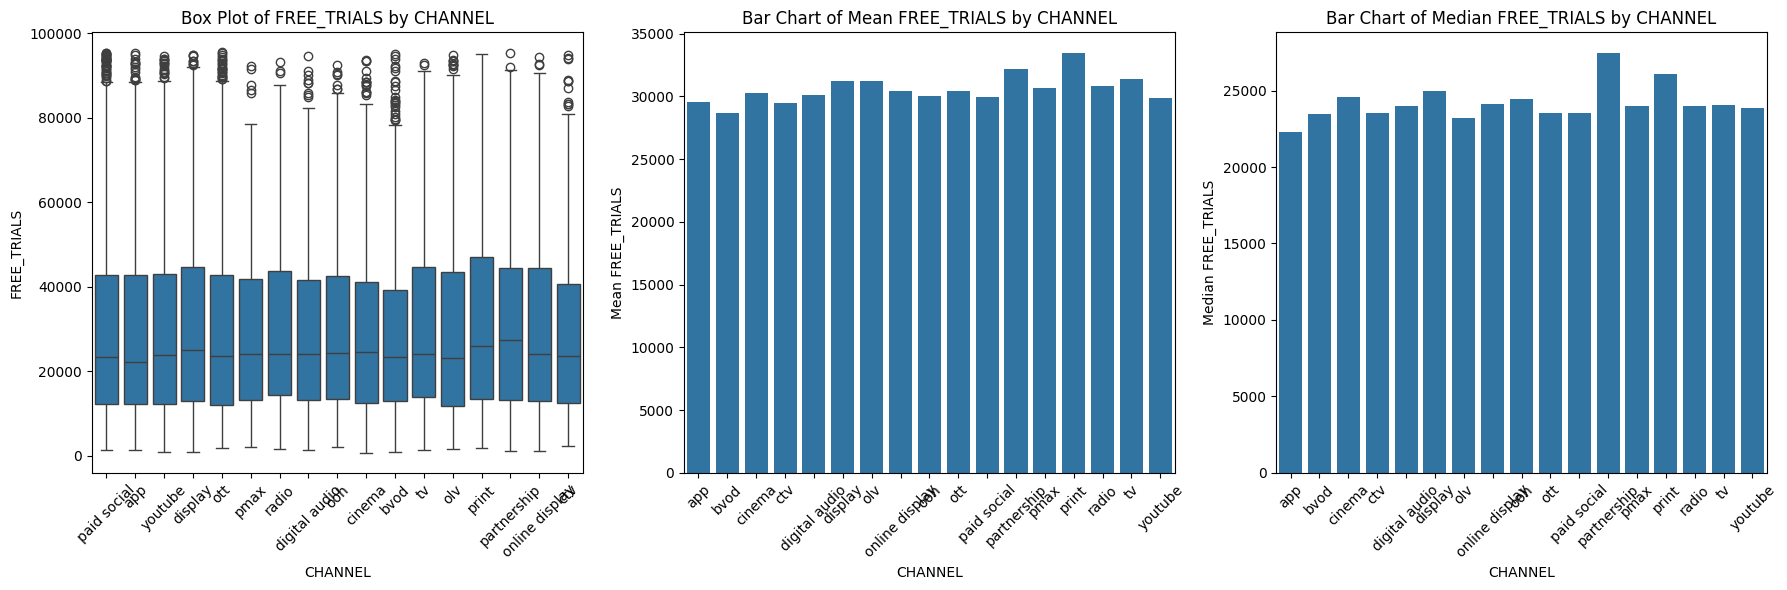

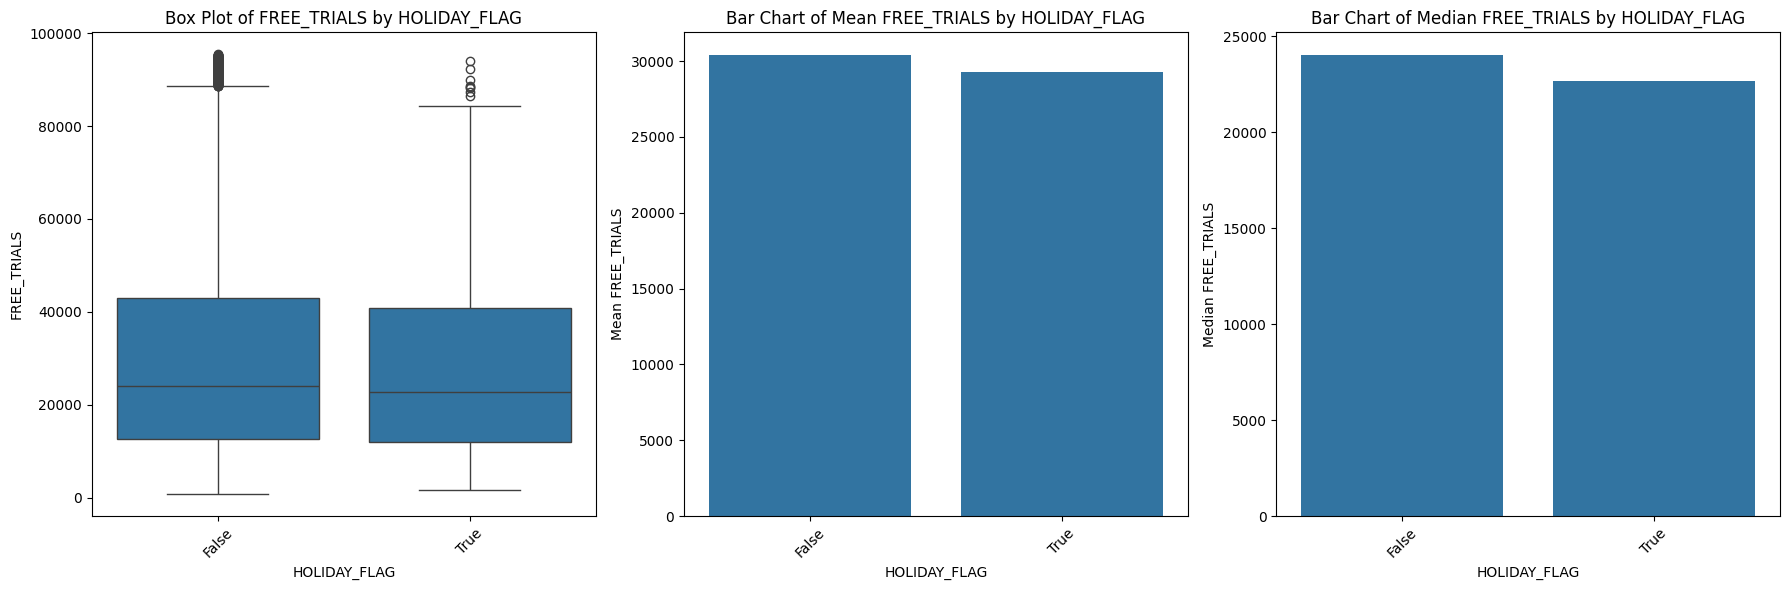

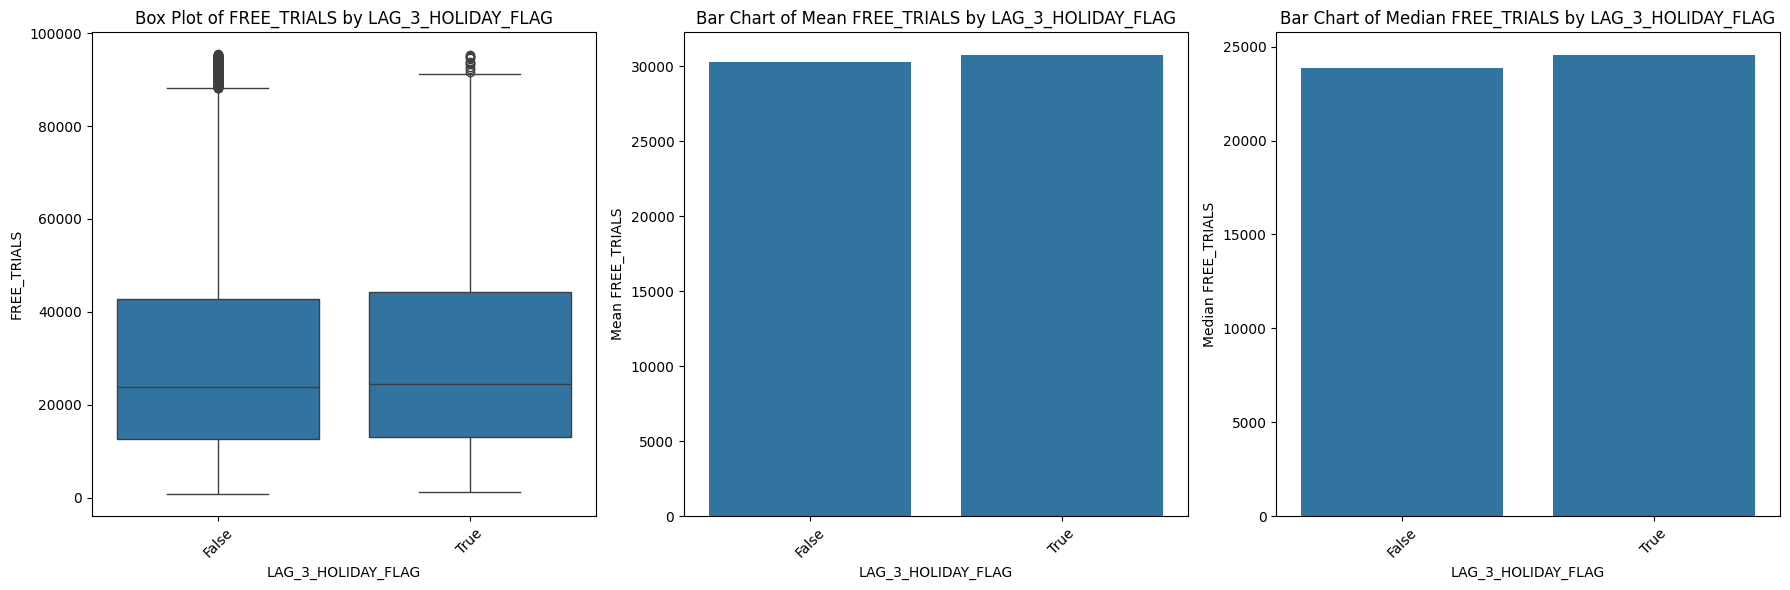

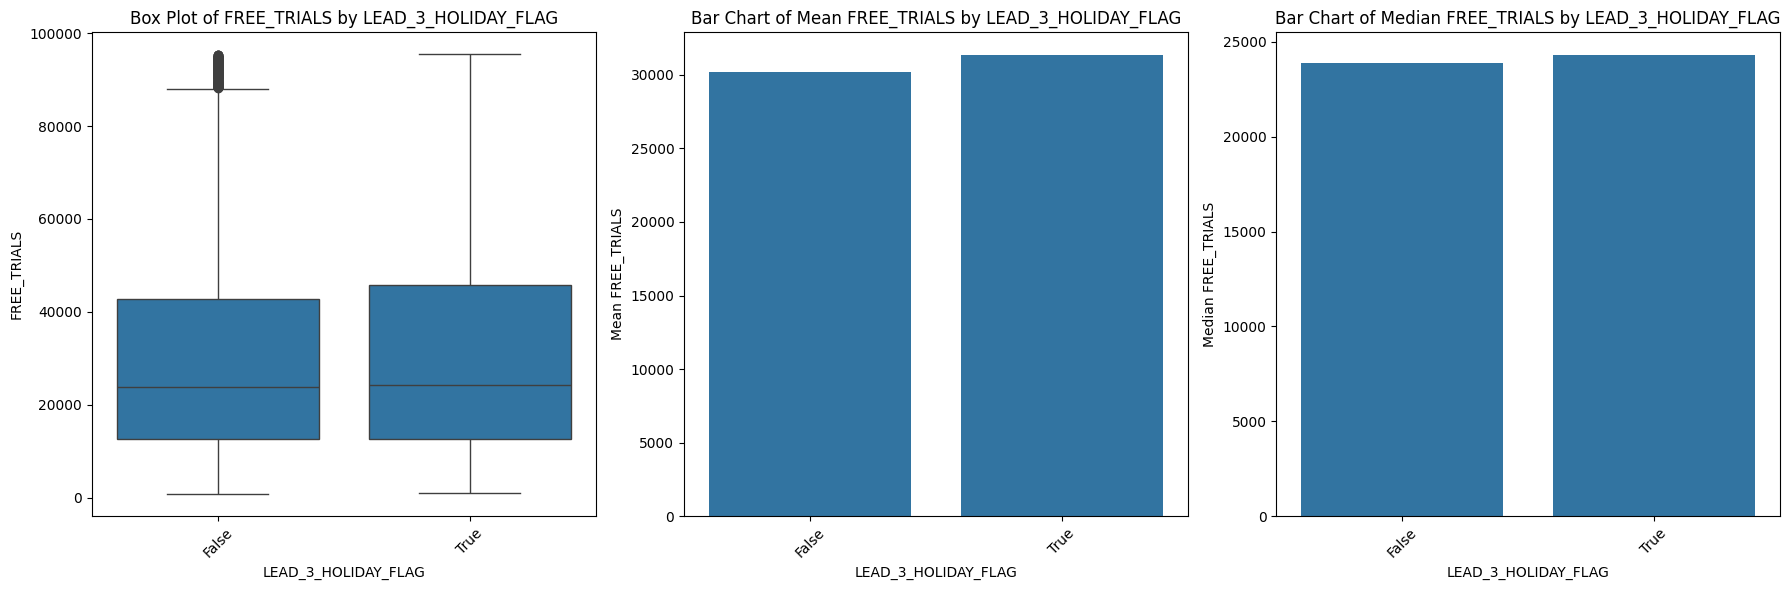

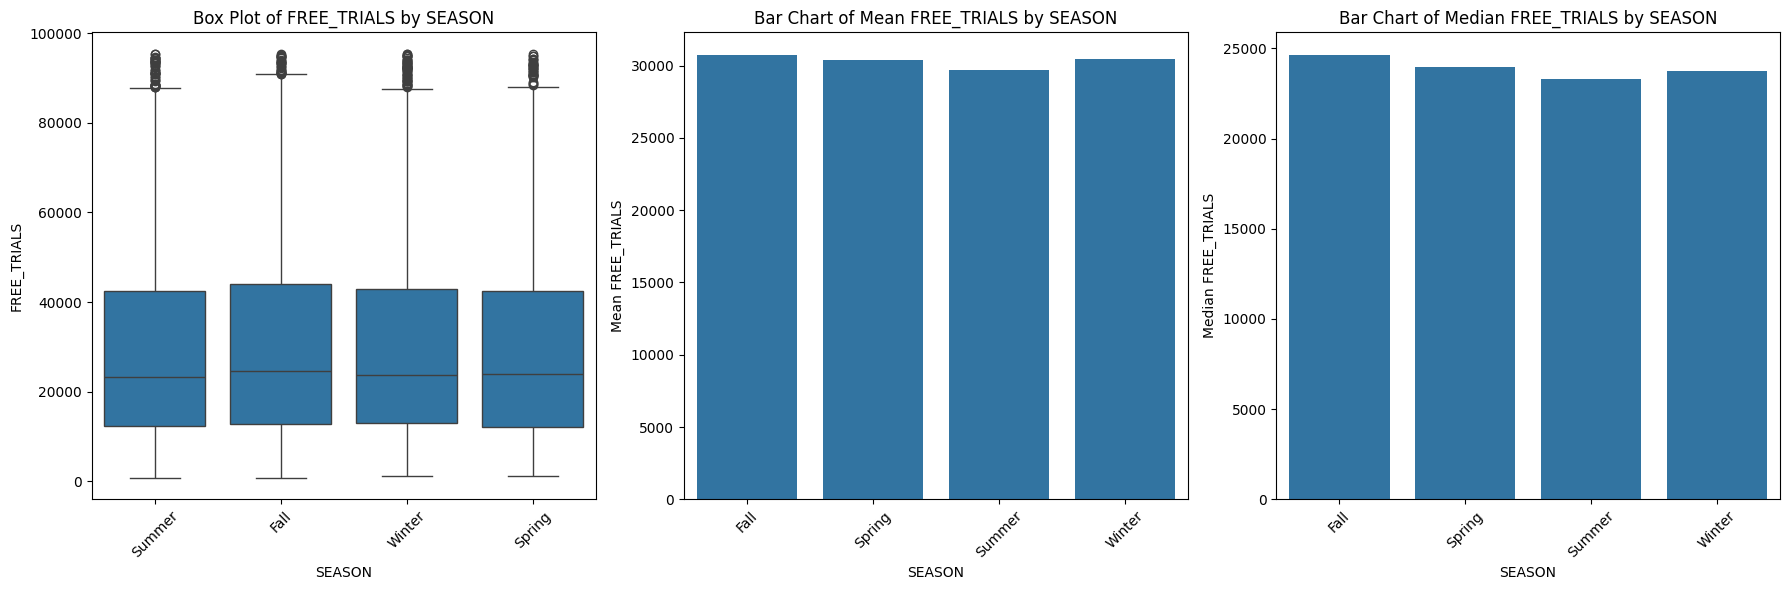

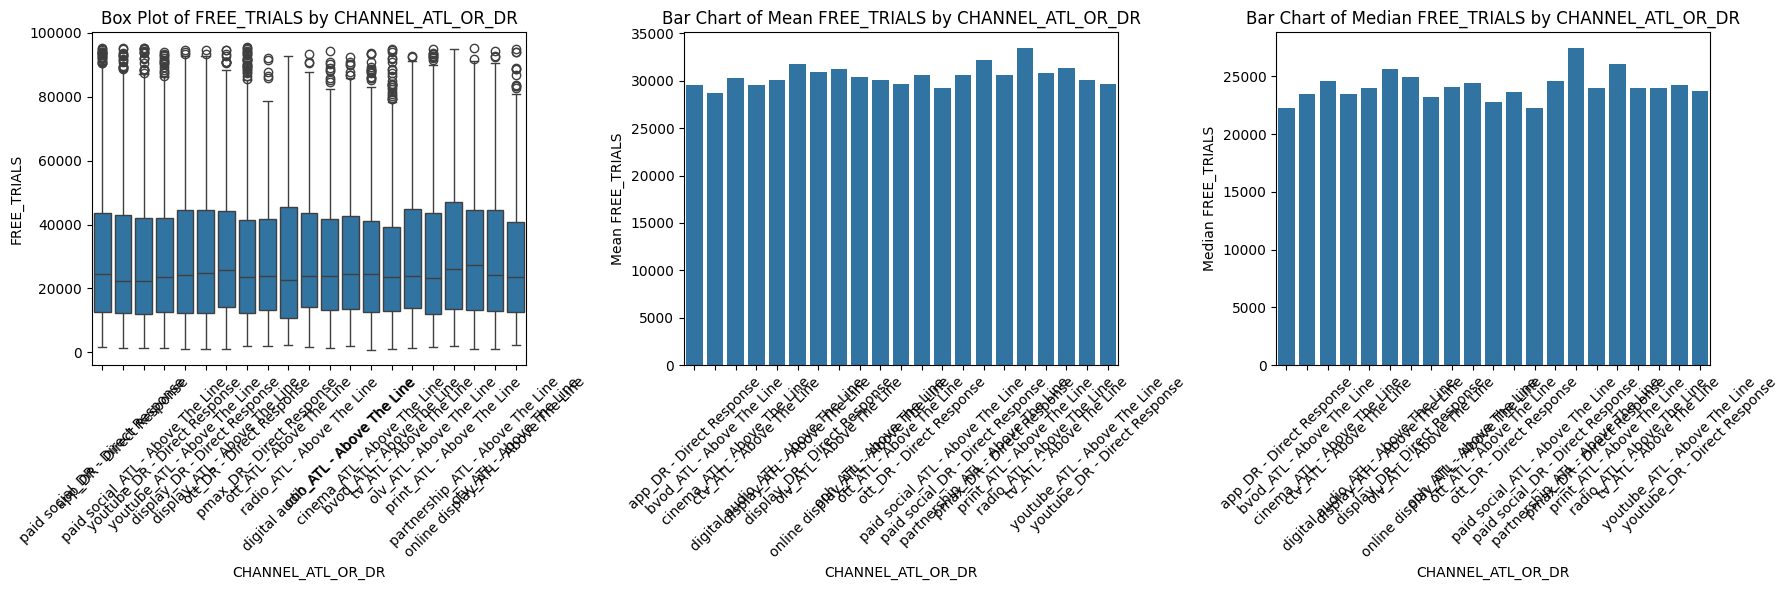

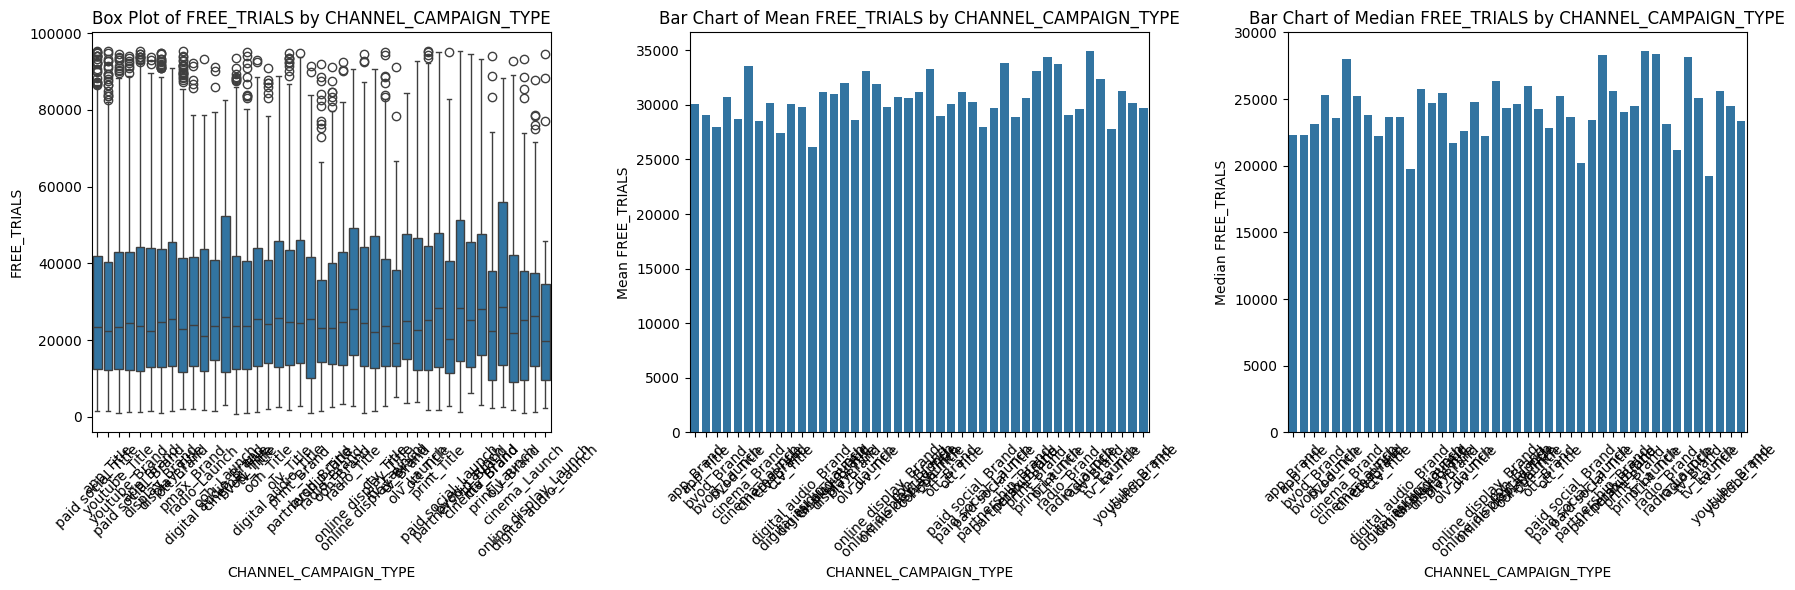

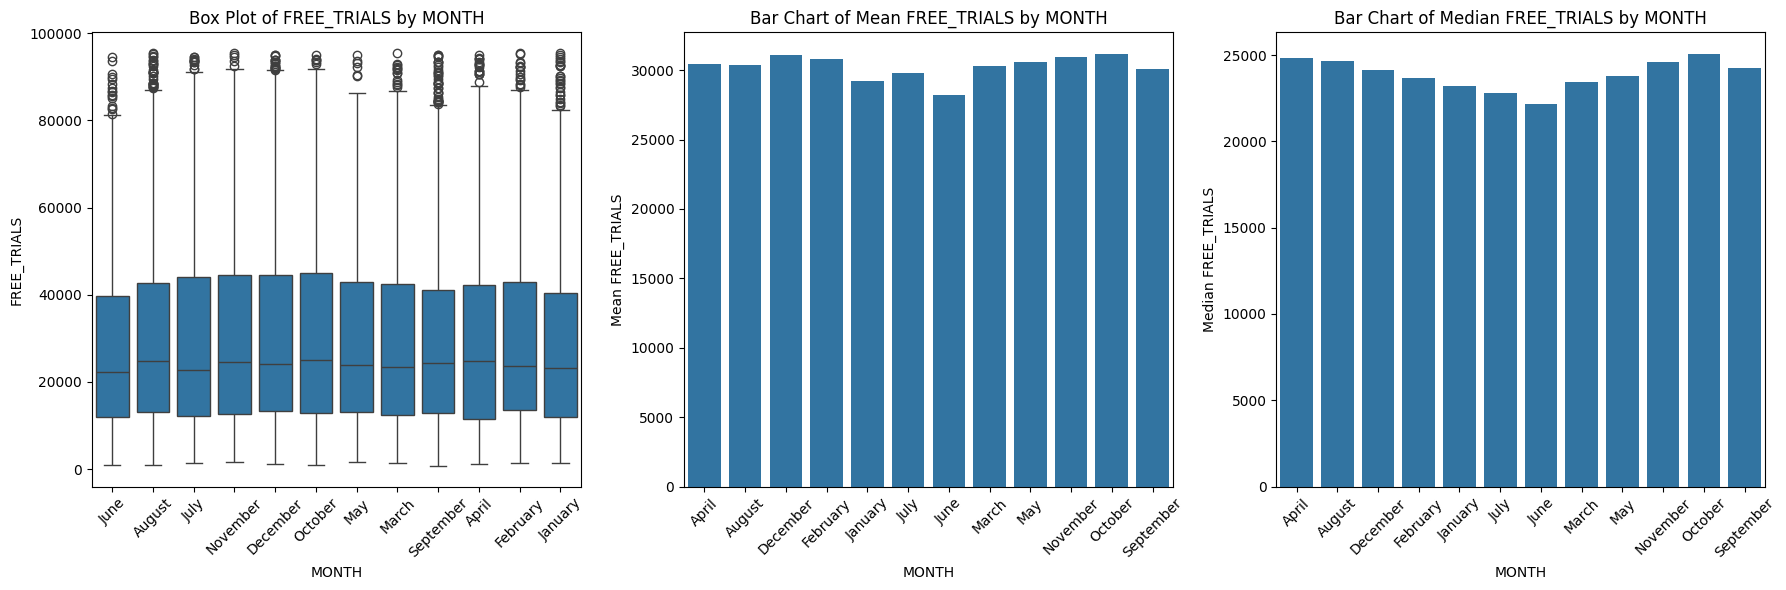

In [18]:
'''
Covariation Analysis between Categorical & Continuous using boxplot and barcharts:

1. ATL/DR doesn't show much of a difference in free trials generated despite ATL/DR being the more
popular choice. CAMPAIGN_TYPE doesn't show much of a difference either.

2. Similarly to cost, different channels have a higher/lower free trials generated. This could be
an influential factor in campaign strategy.

3. Free Trials don't generate higher clicks on holidays than non-holidays. If so, since we know it
cost more to run on holidays, it's better for customers/clients to not run campaigns on holidays.
One factor could be more competition and/or people are spending it with each other.

4. Seasons/months don't show much of a difference in free trials generated.
'''
for category in categorical:
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # Create side-by-side plots

    # Box Plot
    sns.boxplot(x=category, y='FREE_TRIALS', data=df, ax=axes[0])
    axes[0].set_title(f'Box Plot of FREE_TRIALS by {category}')
    axes[0].set_xlabel(category)
    axes[0].set_ylabel('FREE_TRIALS')
    axes[0].tick_params(axis='x', rotation=45)  # Rotate x-axis labels

    # Bar Chart (Mean)
    mean_bar_data = df.groupby(category)['FREE_TRIALS'].mean().reset_index()
    sns.barplot(x=category, y='FREE_TRIALS', data=mean_bar_data, ax=axes[1])
    axes[1].set_title(f'Bar Chart of Mean FREE_TRIALS by {category}')
    axes[1].set_xlabel(category)
    axes[1].set_ylabel('Mean FREE_TRIALS')
    axes[1].tick_params(axis='x', rotation=45)  # Rotate x-axis labels

    # Bar Chart (Median)
    median_bar_data = df.groupby(category)['FREE_TRIALS'].median().reset_index()
    sns.barplot(x=category, y='FREE_TRIALS', data=median_bar_data, ax=axes[2])
    axes[2].set_title(f'Bar Chart of Median FREE_TRIALS by {category}')
    axes[2].set_xlabel(category)
    axes[2].set_ylabel('Median FREE_TRIALS')
    axes[2].tick_params(axis='x', rotation=45)  # Rotate x-axis labels

    # Adjust layout
    plt.tight_layout()
    plt.show()

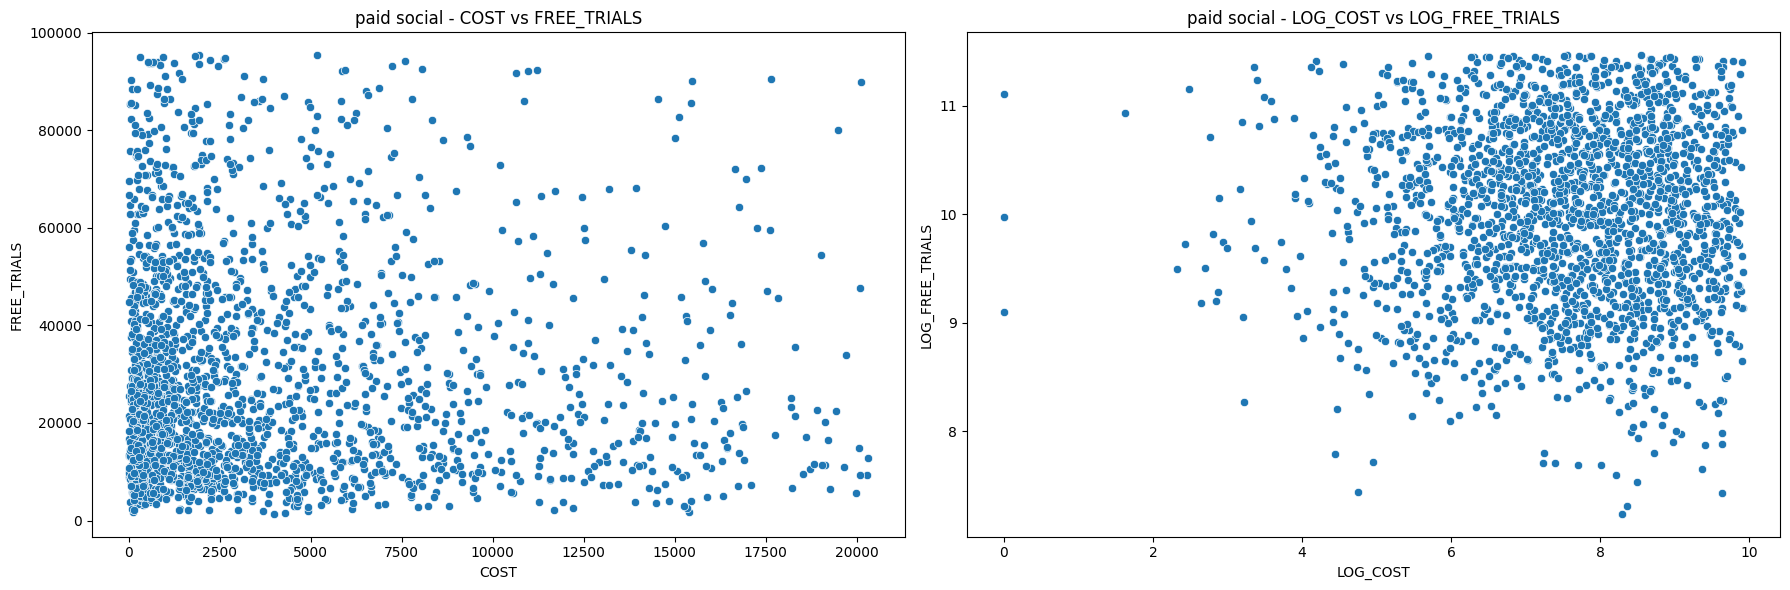

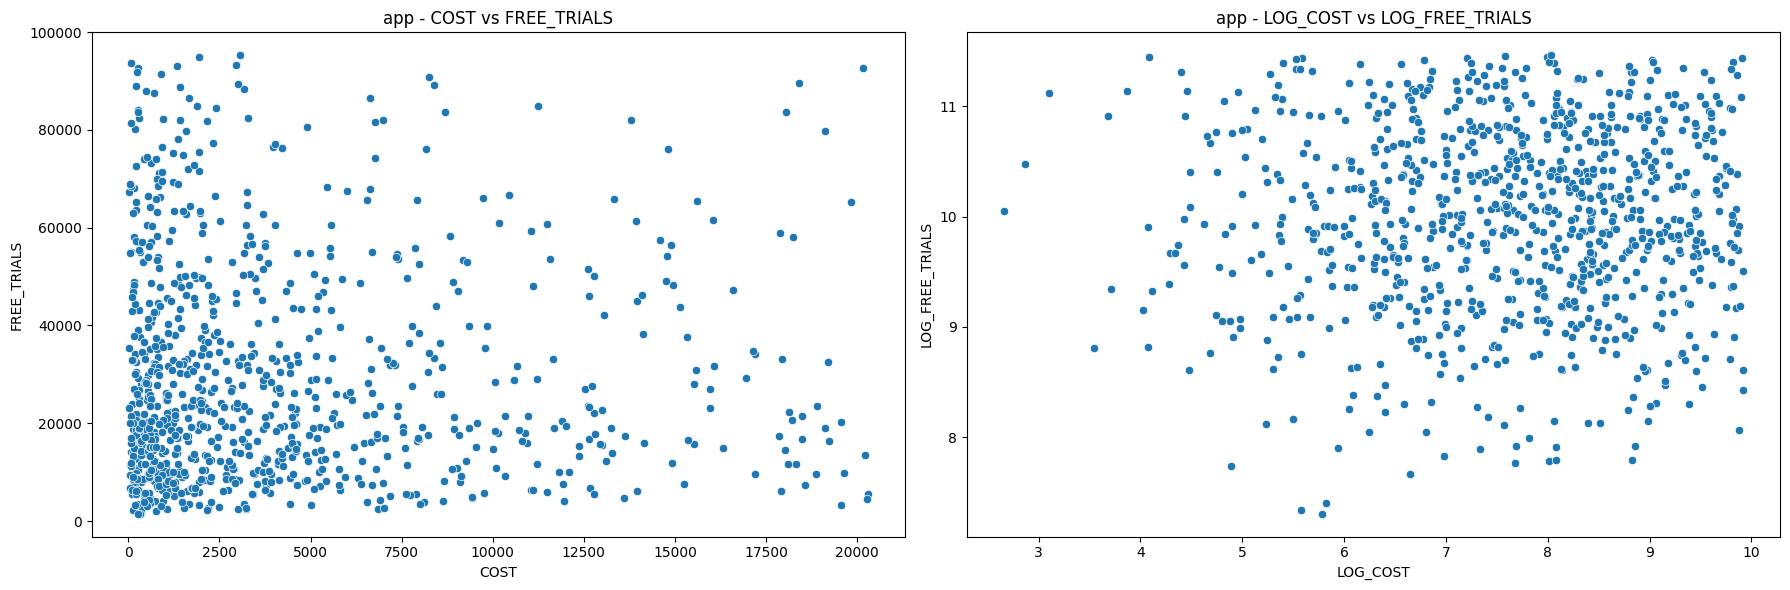

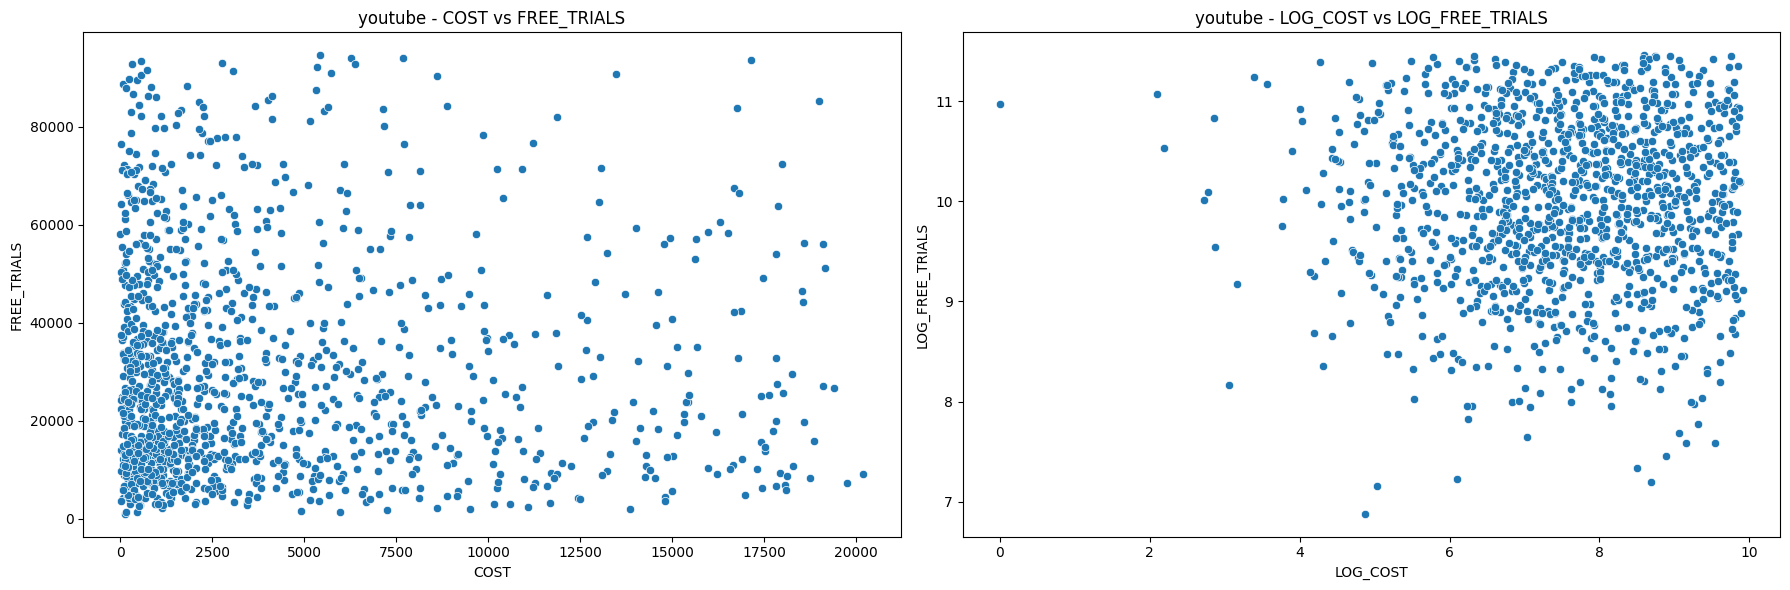

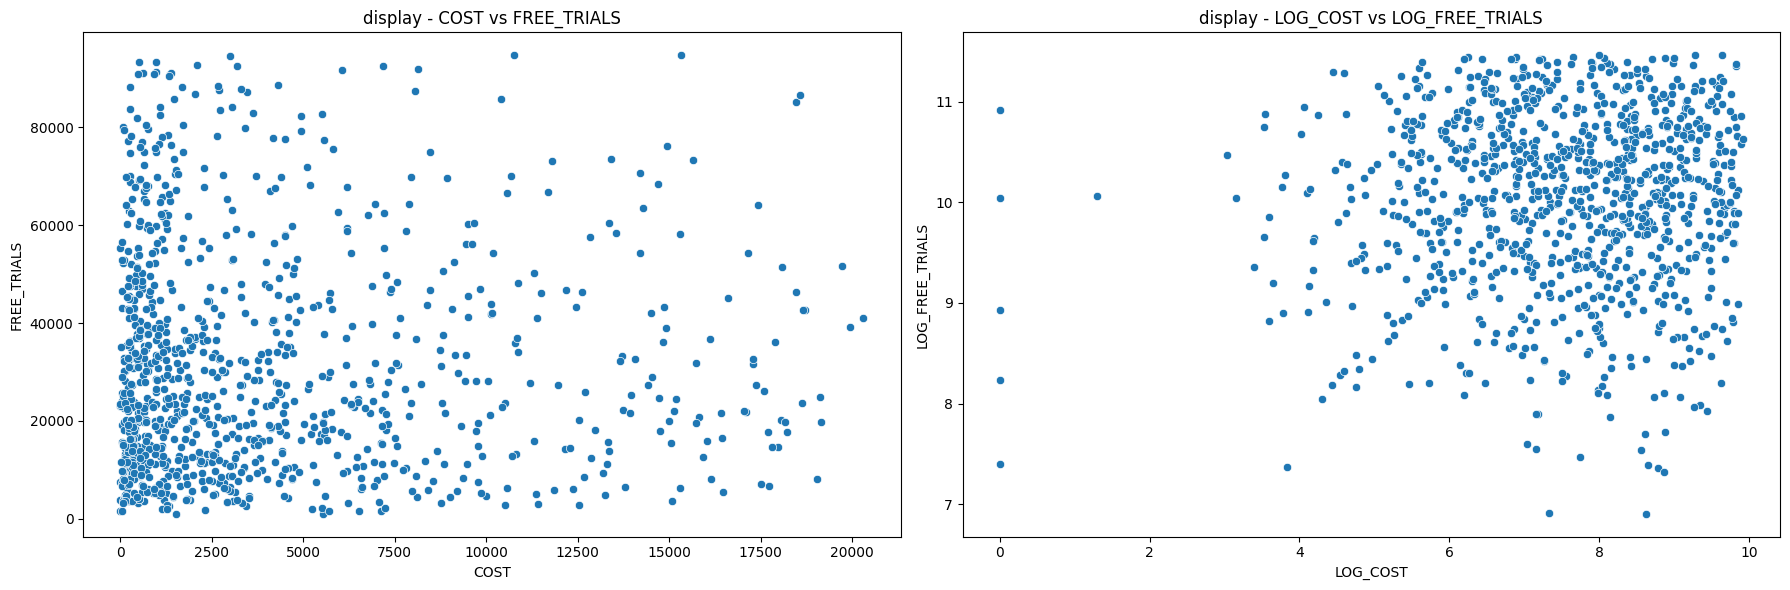

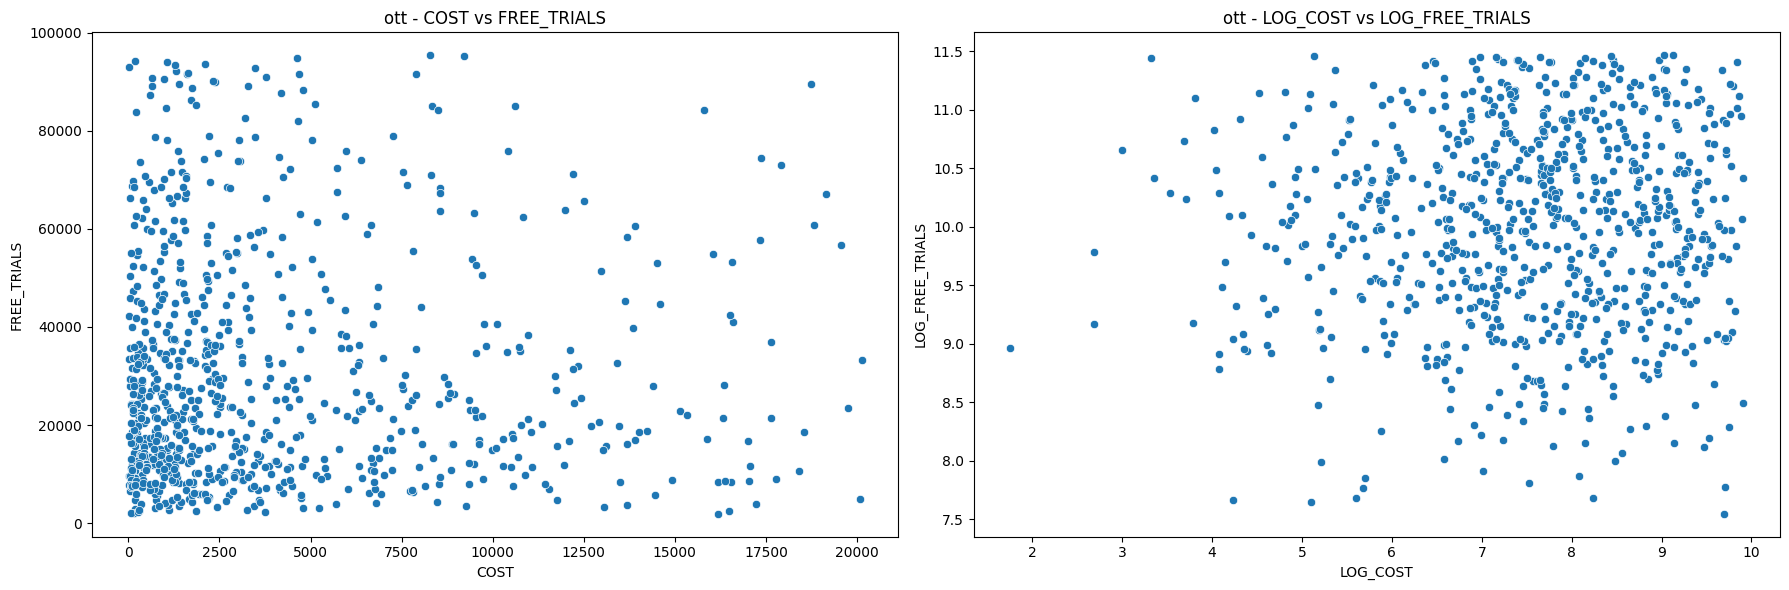

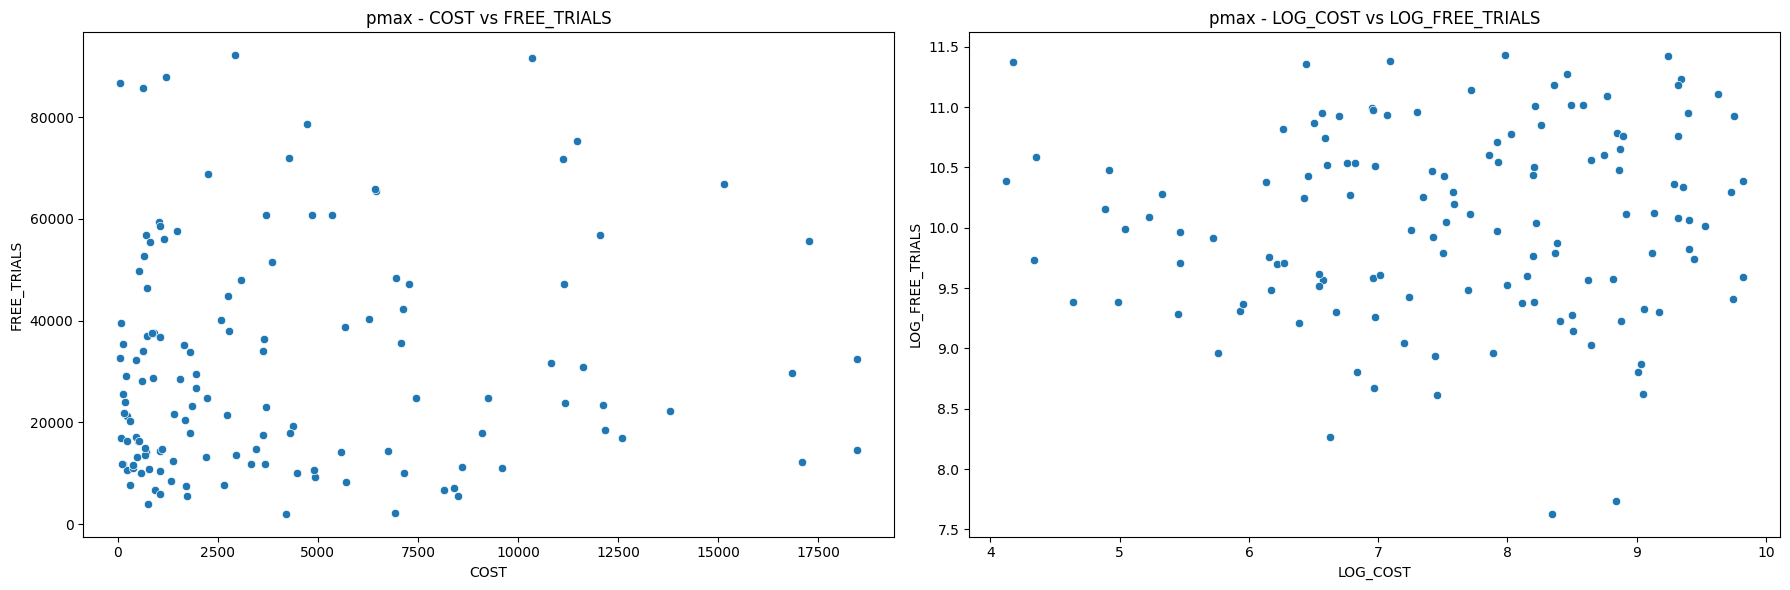

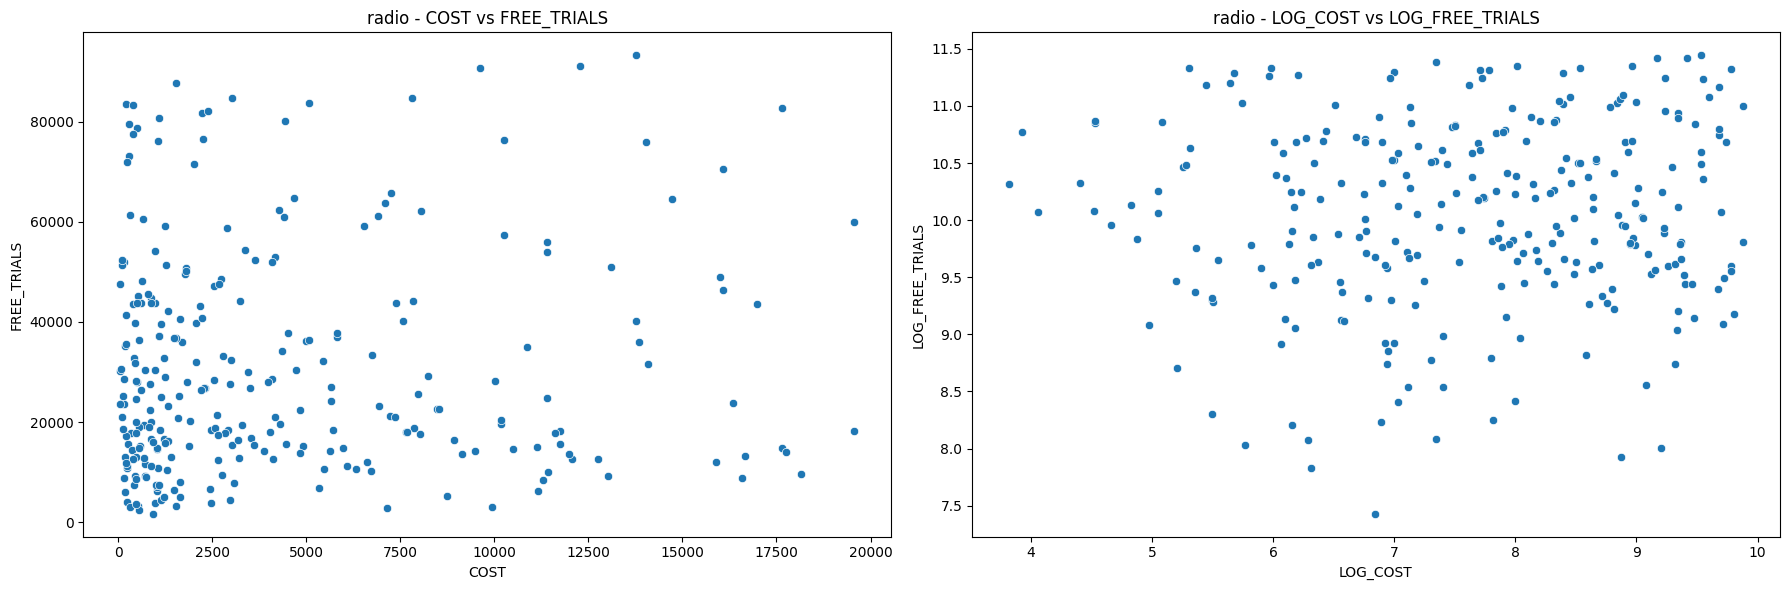

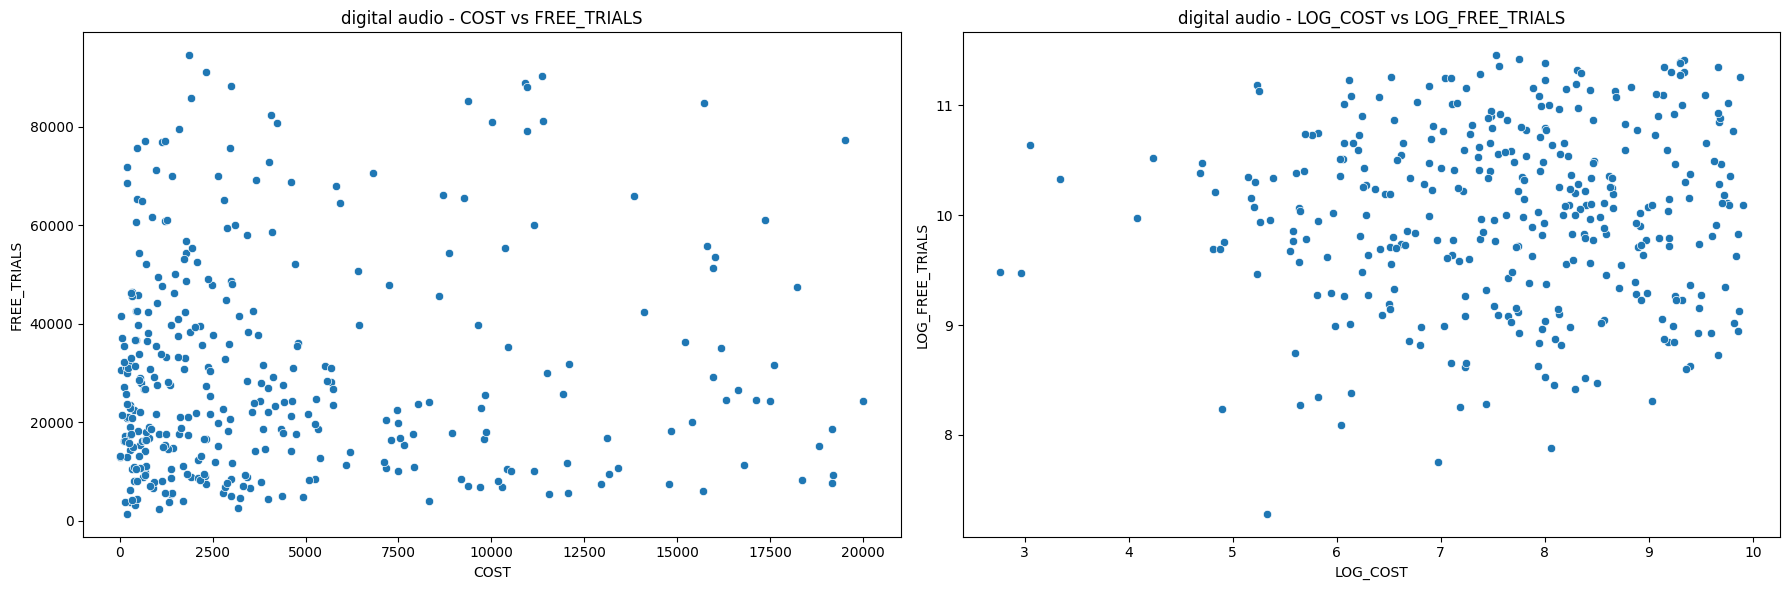

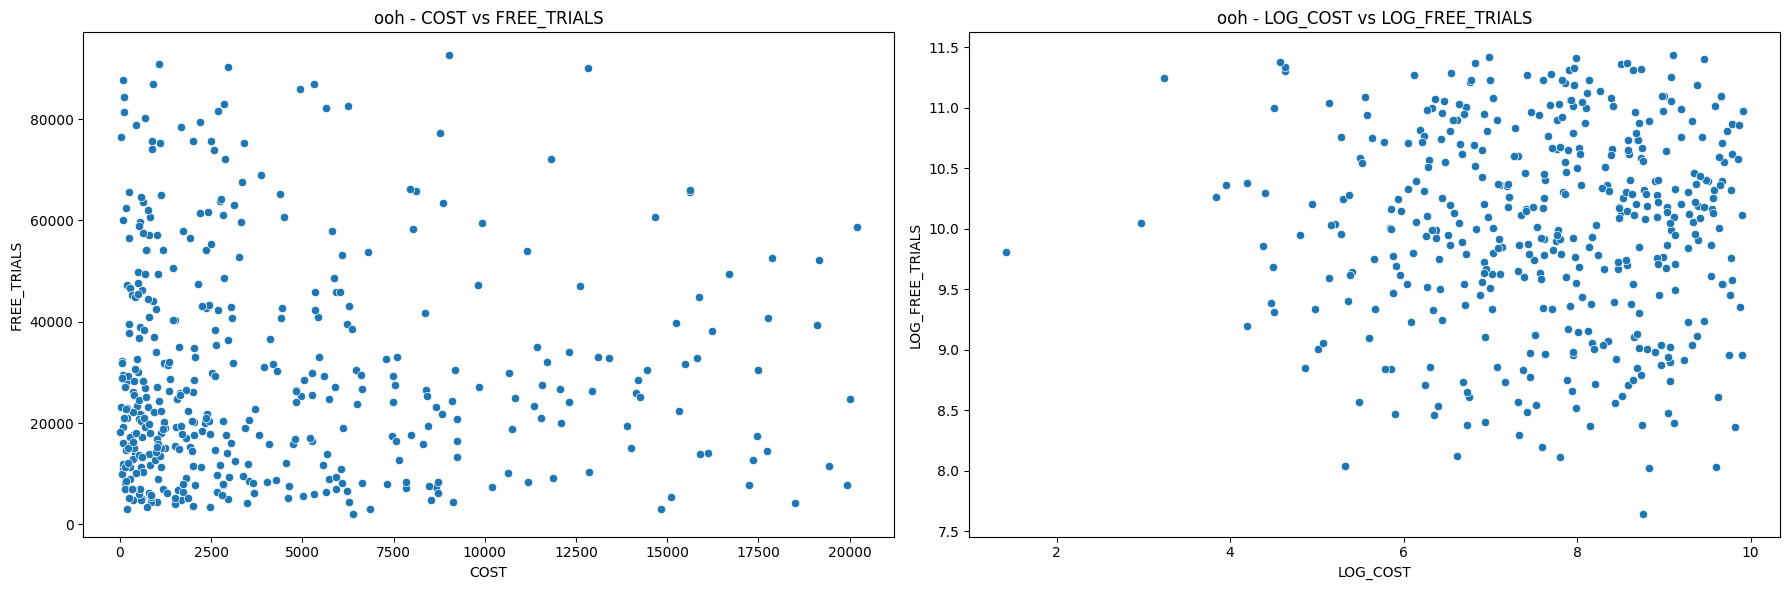

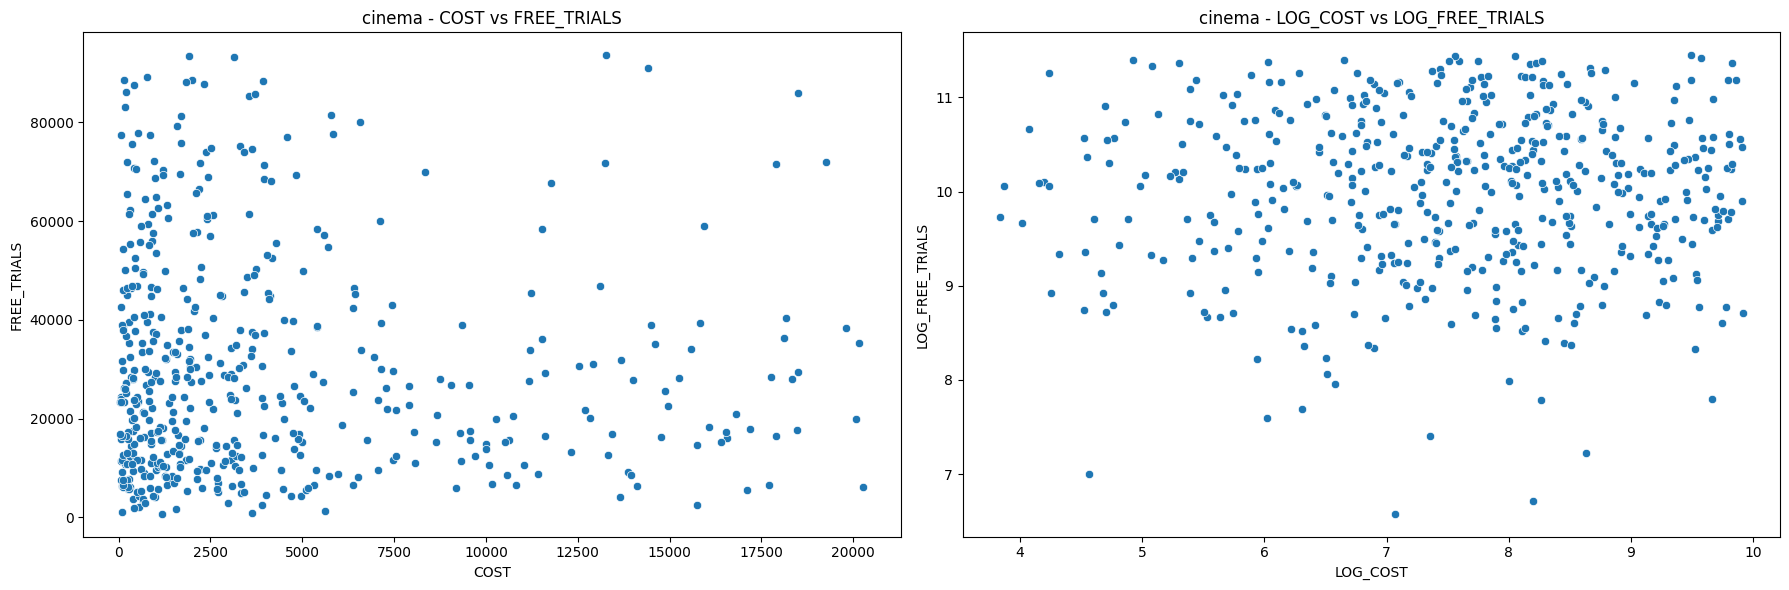

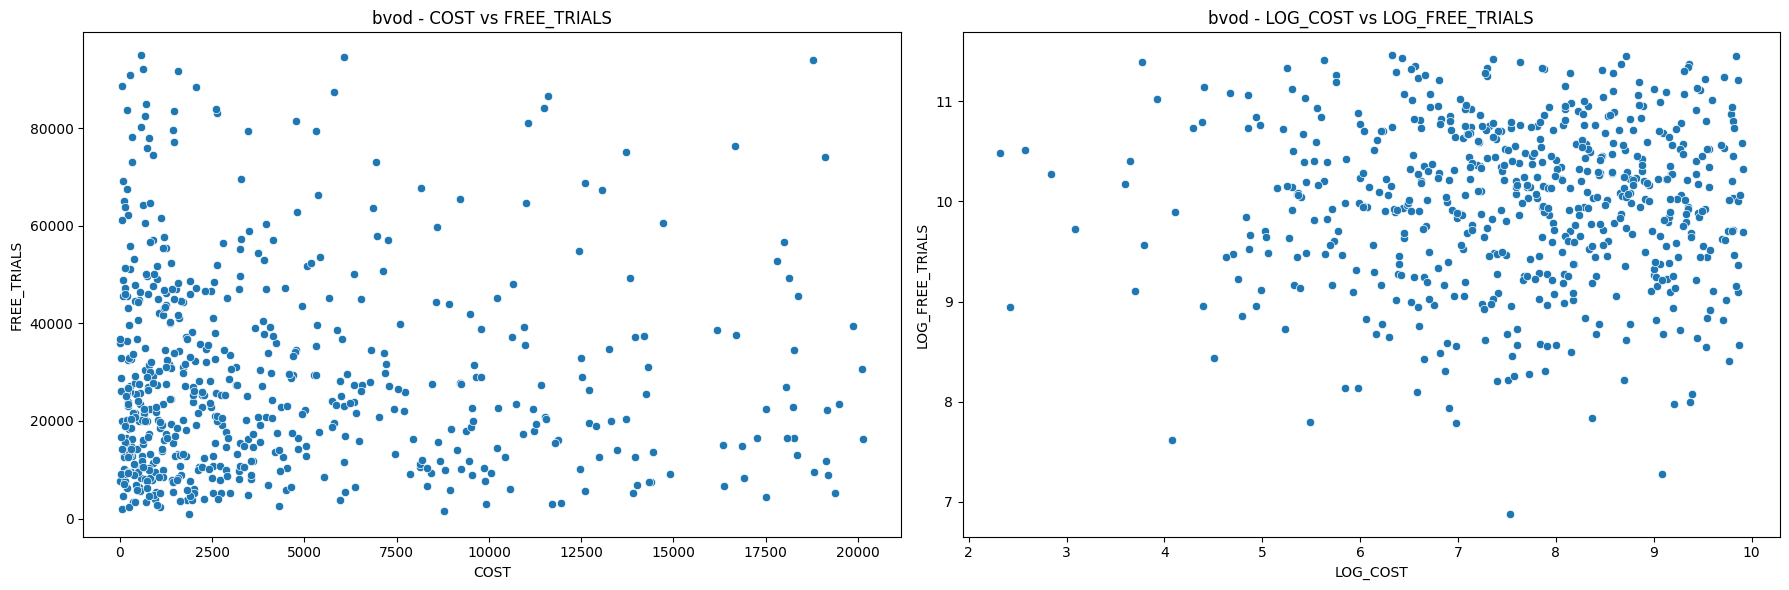

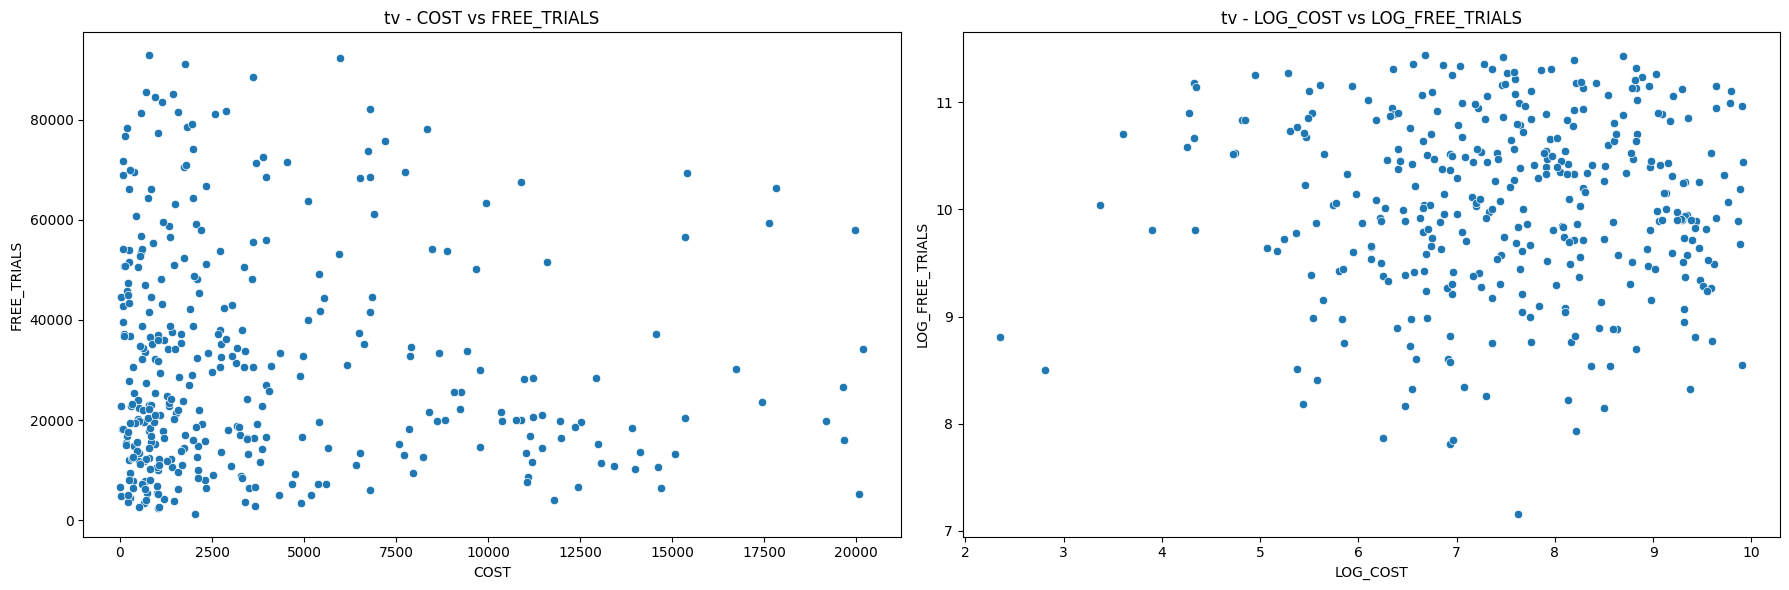

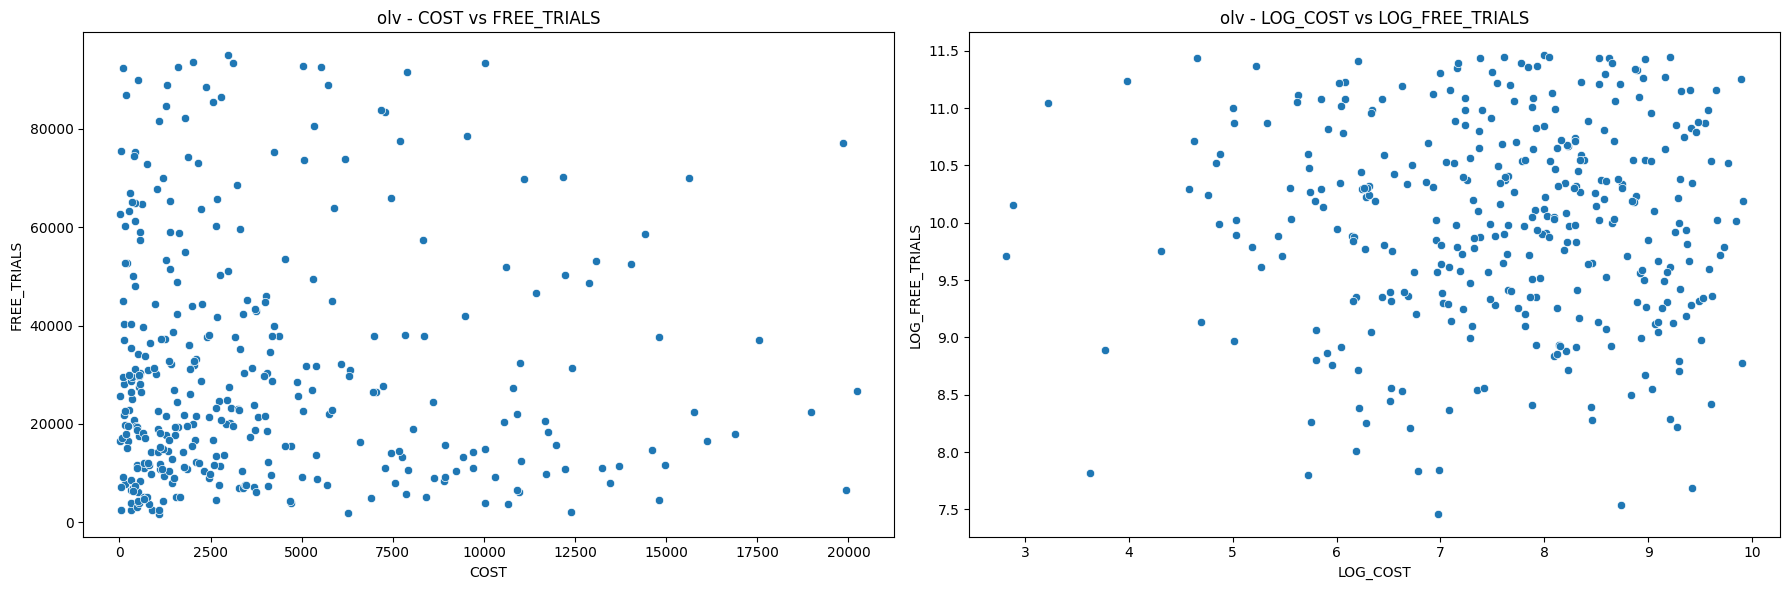

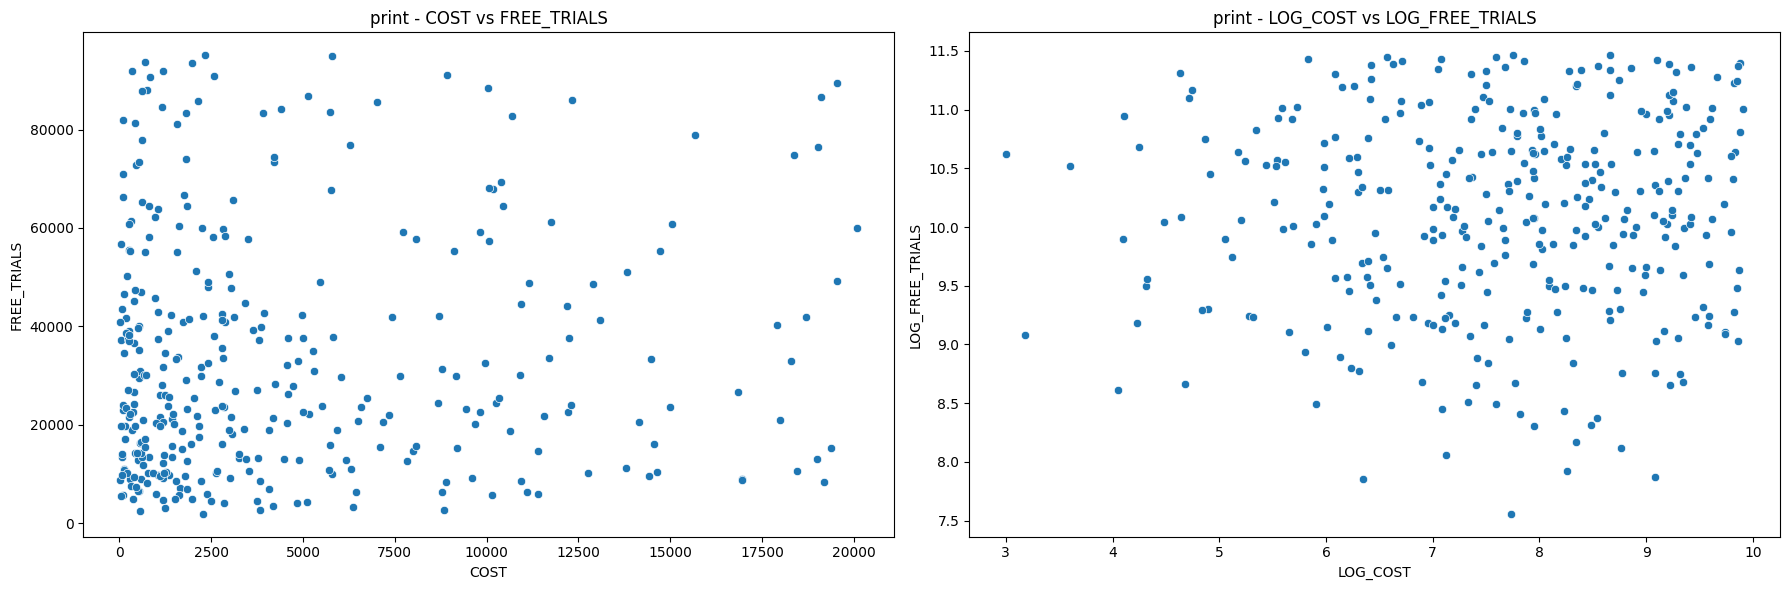

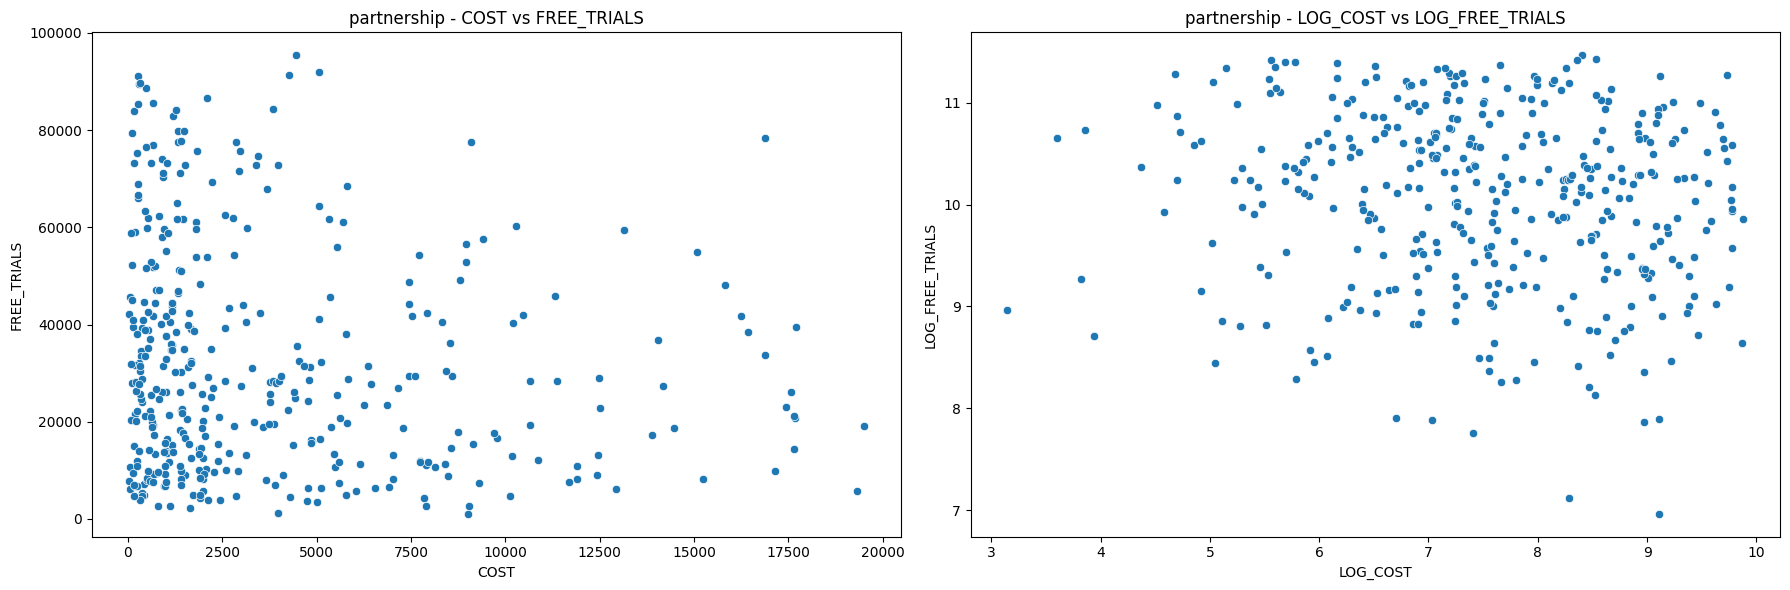

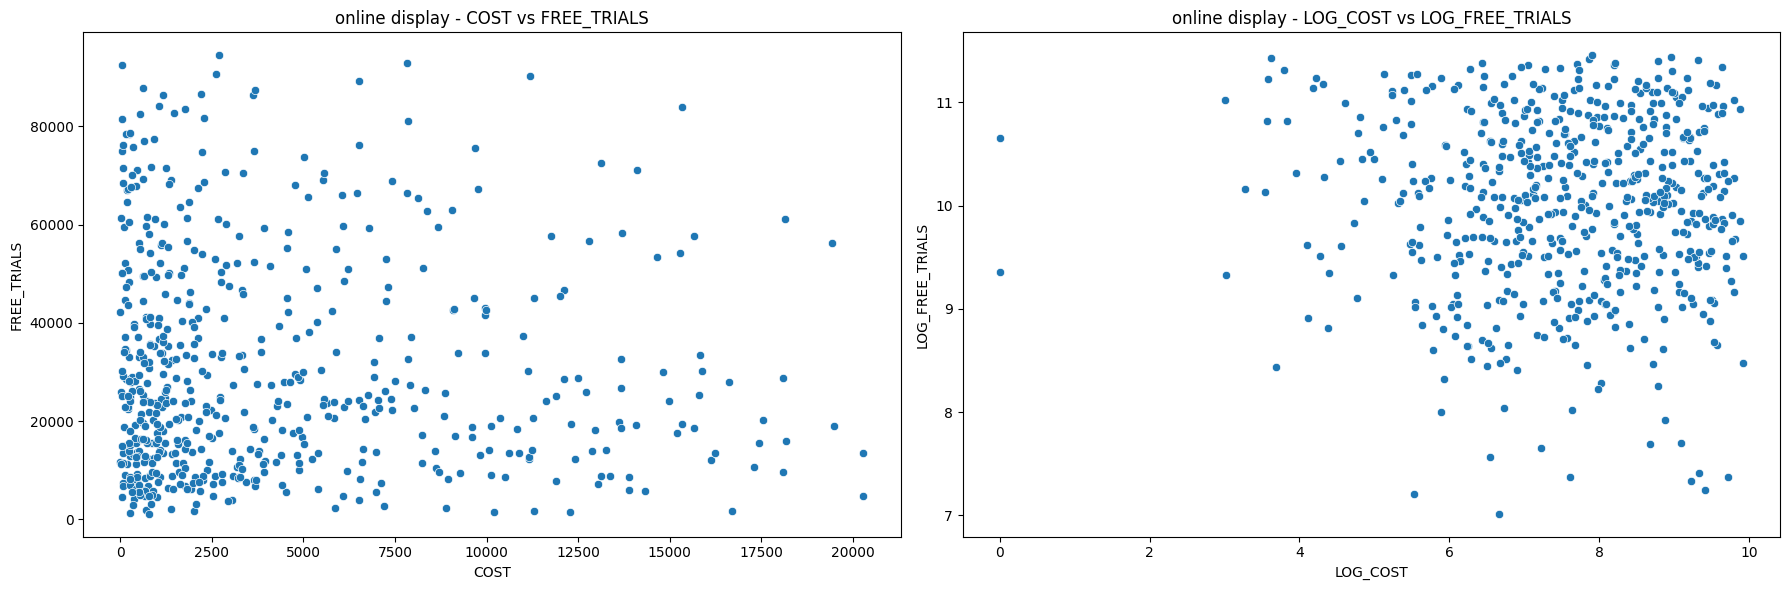

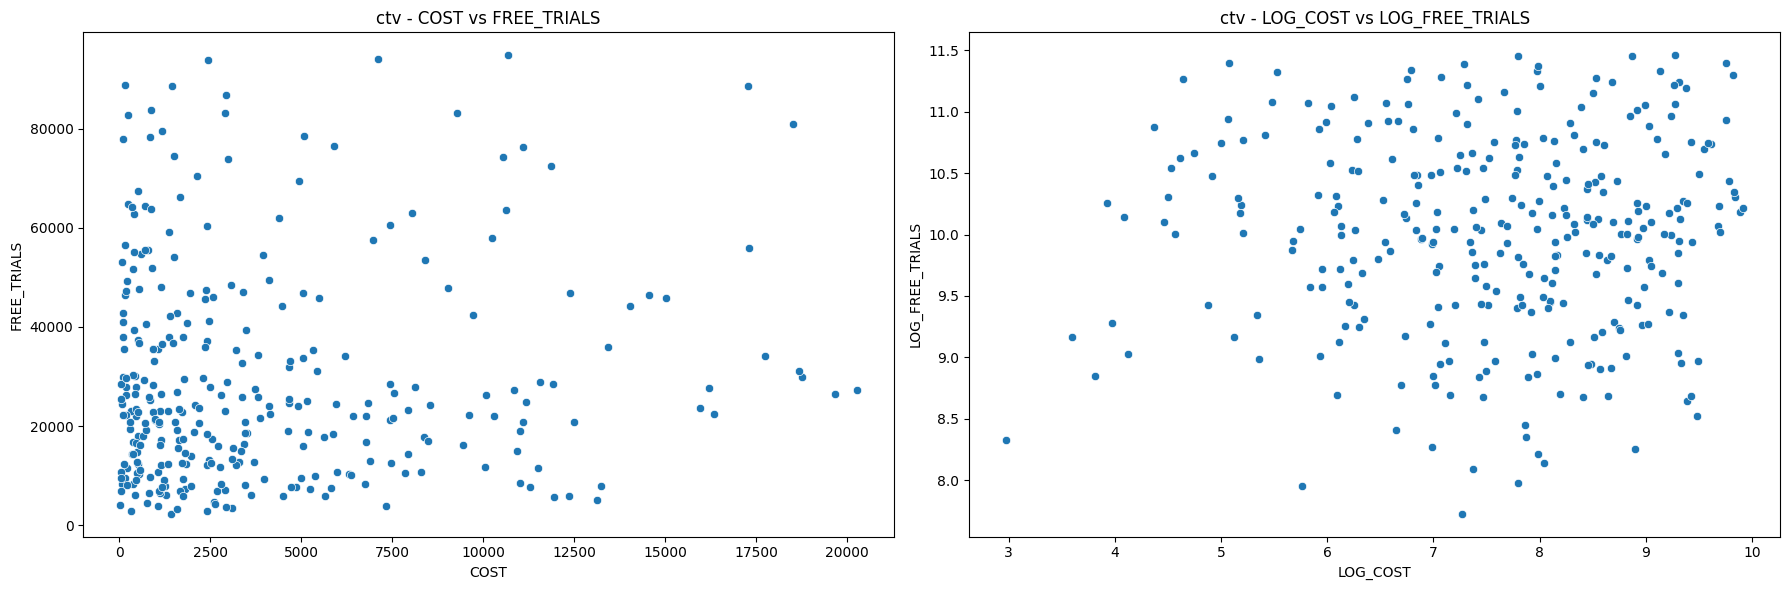

In [19]:
'''
1. When campaign spending is low, there’s higher variability in the number of free trials generated. For all visuals, as
spending increases (especially in paid social campaigns), there’s a diminishing return in the number of free trials generated.
Beyond a certain threshold (around the midpoint in the data), higher spending could lead to higher risks by the form of
fewer free trials.

2. Lot of campaigns that run on Pmax incur high expesnse. After looking into Pmax, these might involve higher upfront costs that decrease over time,
although current data lacks appropriate metadata since unsure when contracts were signed. Meanwhile, Digital Audio campaigns have a lower cost.
'''
values = list(df['CHANNEL'].unique())
for val in values:
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))  # Create side-by-side plots

    data = df[df['CHANNEL'] == val]  # Filter the data for the current value

    # First scatter plot
    sns.scatterplot(data=data, x='COST', y='FREE_TRIALS', ax=axes[0])
    axes[0].set_title(f'{val} - COST vs FREE_TRIALS')
    axes[0].set_xlabel('COST')
    axes[0].set_ylabel('FREE_TRIALS')

    # Second scatter plot
    sns.scatterplot(data=data, x='LOG_COST', y='LOG_FREE_TRIALS', ax=axes[1])
    axes[1].set_title(f'{val} - LOG_COST vs LOG_FREE_TRIALS')
    axes[1].set_xlabel('LOG_COST')
    axes[1].set_ylabel('LOG_FREE_TRIALS')

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

In [20]:
df

REPORT_DATE             ATL_OR_DR CAMPAIGN_TYPE         CHANNEL  \
0      2023-06-09  DR - Direct Response         Title     paid social   
1      2023-08-29  DR - Direct Response         Title             app   
2      2023-07-23  ATL - Above The Line         Title     paid social   
4      2022-08-31  ATL - Above The Line         Title     paid social   
5      2023-08-27  ATL - Above The Line         Title     paid social   
...           ...                   ...           ...             ...   
14101  2023-12-24  ATL - Above The Line         Title             ctv   
14102  2022-07-28  ATL - Above The Line        Launch  online display   
14103  2024-02-23  ATL - Above The Line         Brand            bvod   
14104  2024-04-21  ATL - Above The Line         Title             ooh   
14107  2023-02-17  DR - Direct Response         Title         youtube   

           COST  FREE_TRIALS  HOLIDAY_FLAG  LAG_3_HOLIDAY_FLAG  \
0       7784.31     86401.15         False               False   
1       2474.31      2956.74         False               False   
2      10222.82     12513.08         False               False   
4       2081.06     21758.33         False               False   
5       2081.12     16865.54         False               False   
...         ...          ...           ...                 ...   
14101   1485.02     36855.19         False                True   
14102  19477.42     18960.31         False               False   
14103   1478.78     16941.67         False               False   
14104    839.25      5727.03         False               False   
14107   7385.46     17770.26         False                True   

       LEAD_3_HOLIDAY_FLAG  SEASON     MONTH  \
0                    False  Summer      June   
1                    False  Summer    August   
2                    False  Summer      July   
4                    False  Summer    August   
5                    False  Summer    August   
...                    ...     ...       ...   
14101                False  Winter  December   
14102                False  Summer      July   
14103                False  Winter  February   
14104                False  Spring     April   
14107                False  Winter  February   

                         CHANNEL_ATL_OR_DR  CHANNEL_CAMPAIGN_TYPE  \
0         paid social_DR - Direct Response      paid social_Title   
1                 app_DR - Direct Response              app_Title   
2         paid social_ATL - Above The Line      paid social_Title   
4         paid social_ATL - Above The Line      paid social_Title   
5         paid social_ATL - Above The Line      paid social_Title   
...                                    ...                    ...   
14101             ctv_ATL - Above The Line              ctv_Title   
14102  online display_ATL - Above The Line  online display_Launch   
14103            bvod_ATL - Above The Line             bvod_Brand   
14104             ooh_ATL - Above The Line              ooh_Title   
14107         youtube_DR - Direct Response          youtube_Title   

       COST_PER_FREE_TRIALS  COST_BY_FREE_TRIALS  LOG_COST  LOG_FREE_TRIALS  \
0                  0.090095         6.725733e+08  8.959994        11.366768   
1                  0.836837         7.315891e+06  7.814121         7.992181   
2                  0.816971         1.279190e+08  9.232476         9.434610   
4                  0.095644         4.528039e+07  7.641113         9.987798   
5                  0.123395         3.509921e+07  7.641142         9.733087   
...                     ...                  ...       ...              ...   
14101              0.040293         5.473069e+07  7.303857        10.514779   
14102              1.027273         3.692979e+08  9.877062         9.850156   
14103              0.087287         2.505300e+07  7.299649         9.737591   
14104              0.146542         4.806410e+06  6.733699         8.653127   
14107              0.415608         1.312415e+08  8.907404   

In [21]:
categorical

['ATL_OR_DR',
 'CAMPAIGN_TYPE',
 'CHANNEL',
 'HOLIDAY_FLAG',
 'LAG_3_HOLIDAY_FLAG',
 'LEAD_3_HOLIDAY_FLAG',
 'SEASON',
 'CHANNEL_ATL_OR_DR',
 'CHANNEL_CAMPAIGN_TYPE',
 'MONTH']

In [22]:
# df.drop(columns='REPORT_DATE', axis=1, inplace=True)
# df.to_csv('../../data/log_data_fe_reducedoutliers.csv', index=False)

In [23]:
df.drop(columns='REPORT_DATE', axis=1, inplace=True)
df.to_csv('../../data/log_data_fe_cleaned_v1.0.csv', index=False)